# Orion Wills and Sandy Graham's Analysis 
# of Fitbit Data from Unknown User

In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from proj_acquire import *
from proj_prepare import *

import zgulde.extend_pandas as ep
import seaborn as sns
from statsmodels.tsa.api import Holt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

In [2]:
df = prepare_fitbit()

In [3]:
# rename index to date
df.rename(columns={'index': 'date'}, inplace=True)

# set date to index
df.set_index('date', inplace=True)

# dropping columns with mostly zero information
to_drop = ['calories', 'carbs', 'fat', 'fiber',
       'protien', 'sodium', 'water']
df = df.drop(columns=(to_drop))

# remove commas and convert to float64
for col in df:
    df[col] = df[col].str.replace(',', '')
    df[col] = df[col].astype('float64')

# drop NaN rows as we'll be predicting them anyway
df.dropna(inplace=True)

### Exploration:

In [4]:
for col in df:
    print(f'{col} outliers:{df[col].outliers().sum()}')

activity_calories outliers:3
distance outliers:1
floors outliers:12
mins_active_high outliers:0
mins_active_light outliers:17
mins_active_med outliers:11
mins_sedentary outliers:22
steps outliers:1
total_calories outliers:4


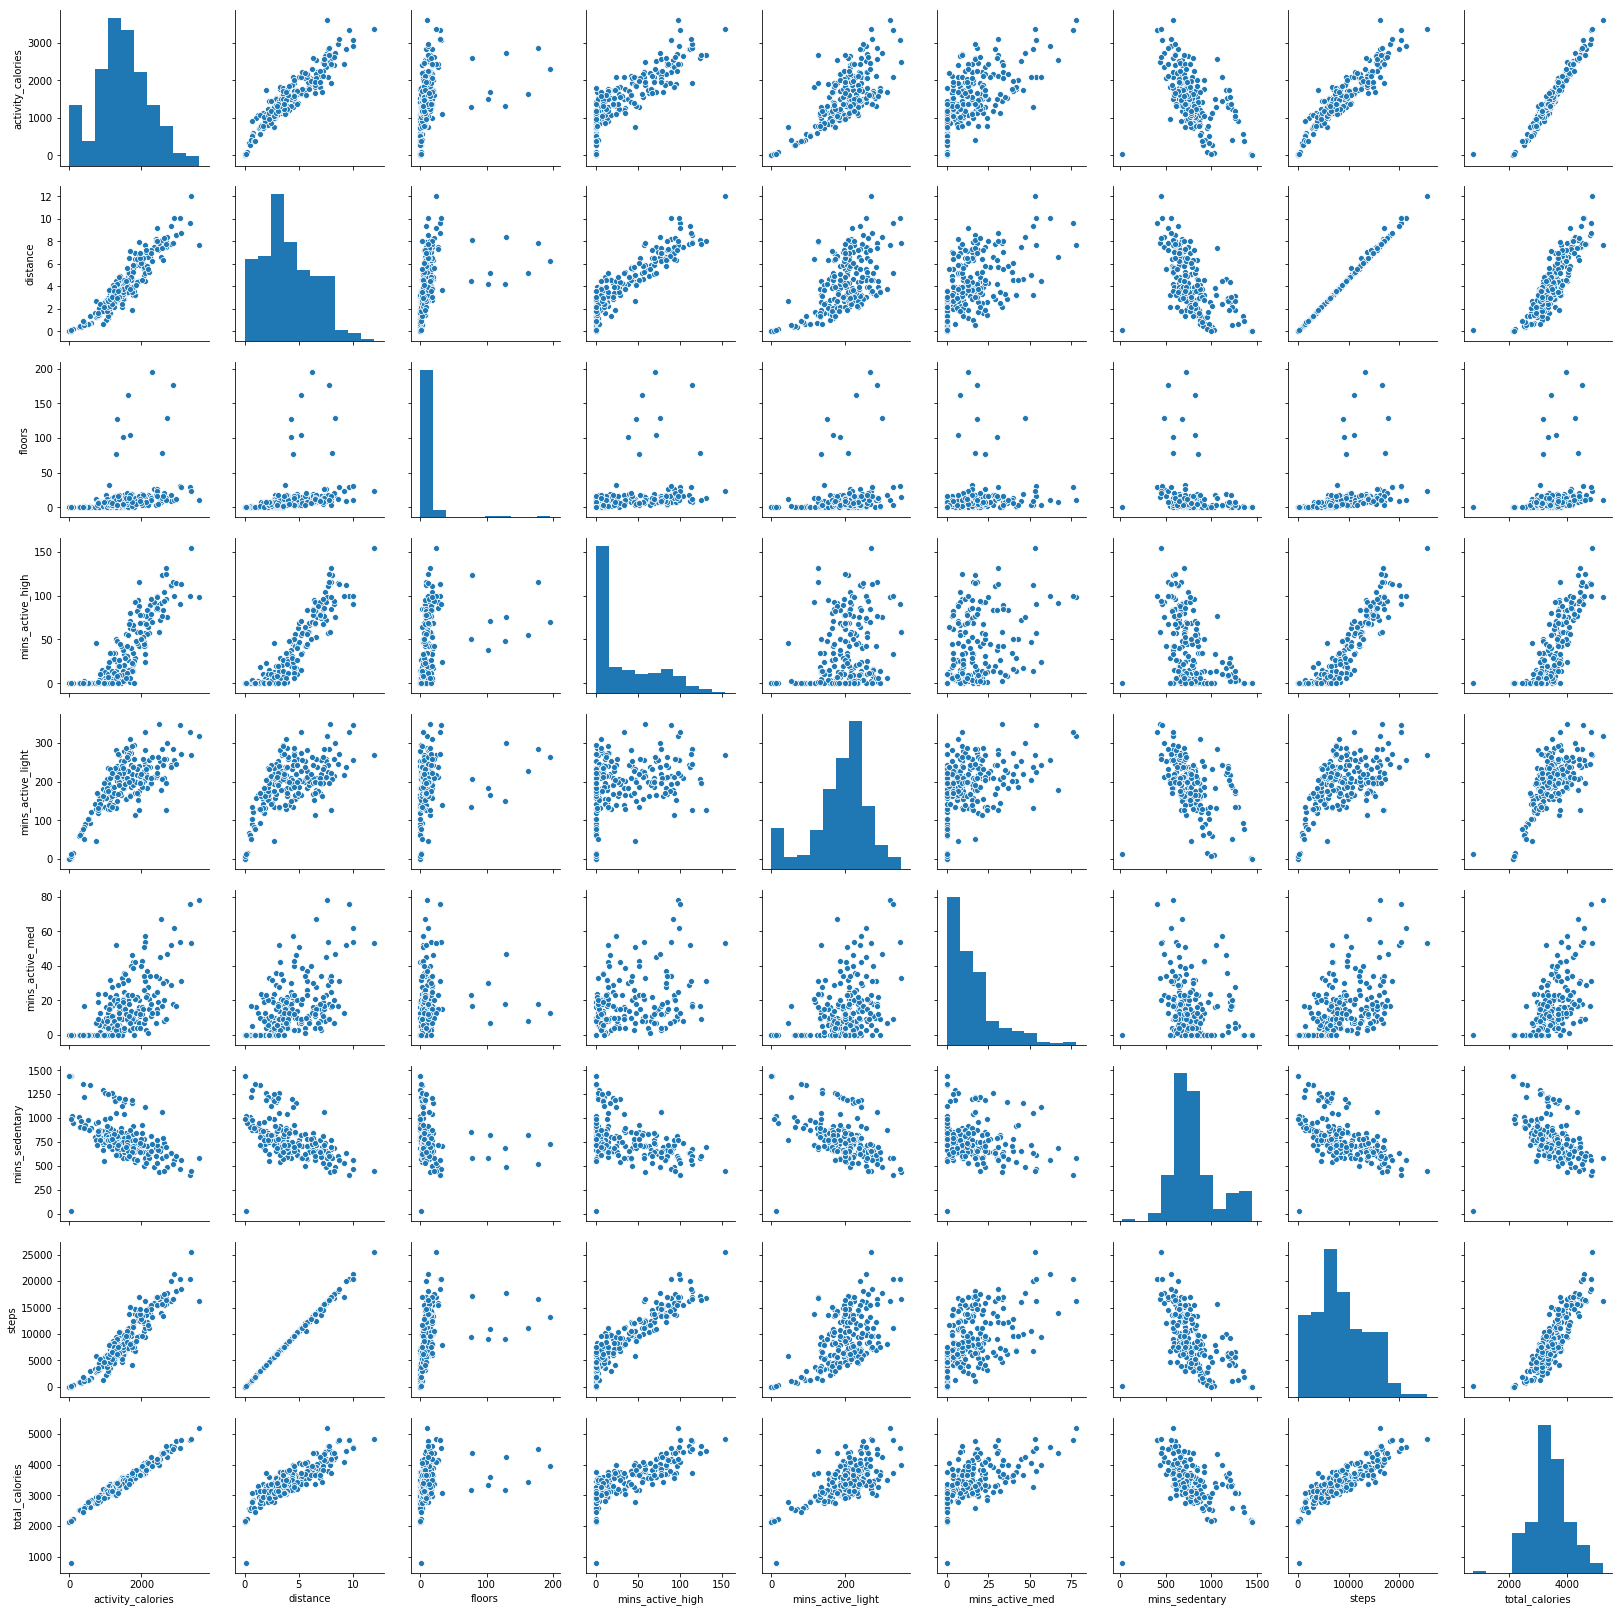

In [5]:
sns.pairplot(df)

<module 'matplotlib.pyplot' from '/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

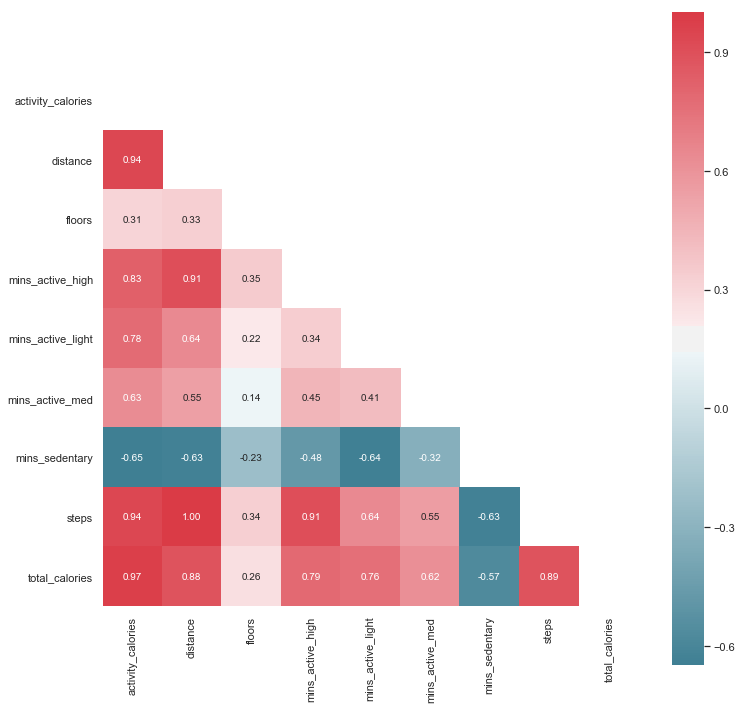

In [6]:
df.correlation_heatmap(fancy=True)

Clearly, steps and distance are very highly correlated, which makes sense. But we aren't sure which to keep, yet.

In [7]:
def peekatdata(df):
    '''gives cursory sample of dataframe passed'''
    head_df = df.head(5)
    print(head_df)
    tail_df = df.tail(5)
    print(tail_df)
    shape_tuple = df.shape
    print(shape_tuple)
    describe_df = df.describe()
    print(describe_df)
    df.info()

In [8]:
train = df['2018-04':'2018-09']
test = df['2018-10':'2018-12']
print(train.nunique())
print(test.nunique())

activity_calories    145
distance             130
floors                25
mins_active_high      60
mins_active_light    108
mins_active_med       46
mins_sedentary       131
steps                146
total_calories       145
dtype: int64
activity_calories    65
distance             63
floors               31
mins_active_high     50
mins_active_light    53
mins_active_med      32
mins_sedentary       61
steps                67
total_calories       67
dtype: int64


### mean total calories by day

Text(0.5, 0, 'day')

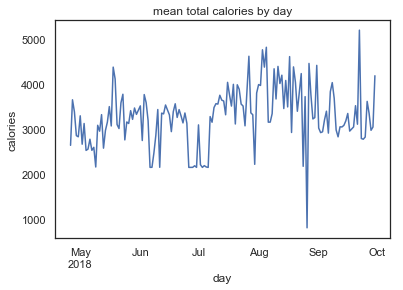

In [9]:
t_cal = train.resample('D').total_calories.mean()
t_cal.plot()
plt.title('mean total calories by day')
plt.ylabel('calories')
plt.xlabel('day')

### mean total calories by week

Text(0.5, 0, 'weeks')

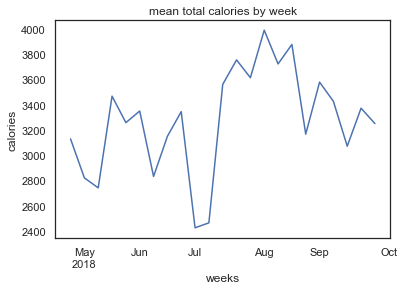

In [10]:
t_cal.resample('W').mean().plot()
plt.title('mean total calories by week')
plt.ylabel('calories')
plt.xlabel('weeks')

### mean total calories by month

Text(0.5, 0, 'month')

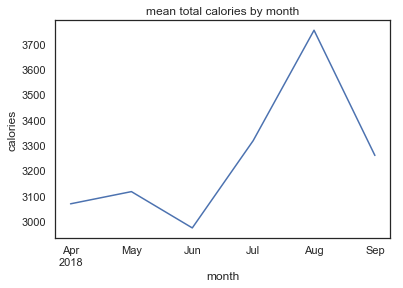

In [11]:
t_cal.resample('M').mean().plot()
plt.title('mean total calories by month')
plt.ylabel('calories')
plt.xlabel('month')

### 5 period rolling mean and plot

In [12]:
t_cal.head(10)

date
2018-04-26    2635.0
2018-04-27    3649.0
2018-04-28    3379.0
2018-04-29    2851.0
2018-04-30    2825.0
2018-05-01    3292.0
2018-05-02    2660.0
2018-05-03    3121.0
2018-05-04    2522.0
2018-05-05    2551.0
Freq: D, Name: total_calories, dtype: float64

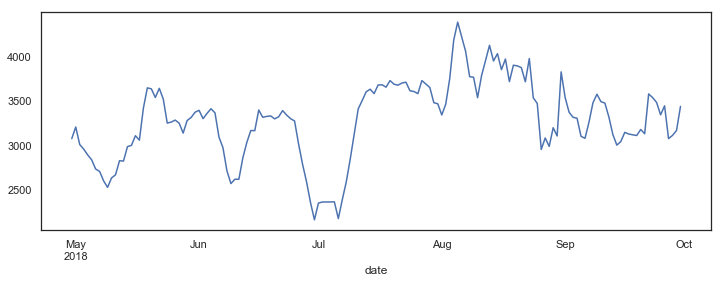

In [13]:
t_cal.rolling(5).mean().plot(figsize=(12, 4))

### 10 period rolling mean and plot

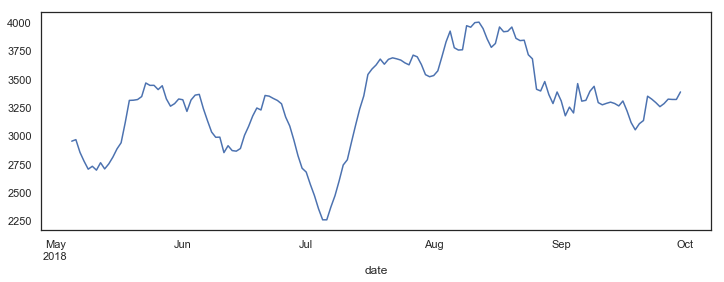

In [14]:
t_cal.rolling(10).mean().plot(figsize=(12, 4))

### Time-series decomposition - trend, seasonality, and noise

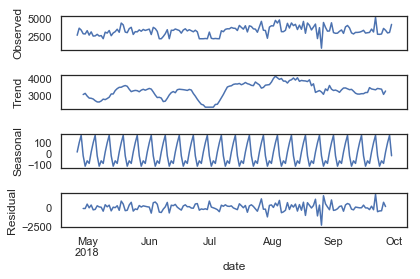

In [15]:
decomposition = sm.tsa.seasonal_decompose(t_cal, model='additive')
fig = decomposition.plot()
plt.show()

### lag plot

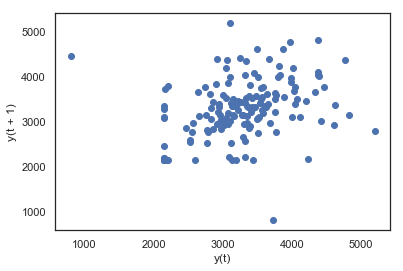

In [16]:
pd.plotting.lag_plot(t_cal)

### pearson's correlation coef

In [17]:
df_corr = pd.concat([t_cal.shift(1), t_cal], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.317357
t+1  0.317357  1.000000


# Modeling

In [18]:
agg1 = 'mean'
agg2 = 'sum'

In [19]:
ts_data1 = df.total_calories.resample('W').agg(agg1)
ts_data2 = df.total_calories.resample('W').agg(agg2)

In [20]:
train_size1 = int(len(ts_data1) * 0.66)
train_1, test_1 = ts_data1[0:train_size1], ts_data1[train_size1:len(ts_data1)]
print('Observations: %d' % (len(ts_data1)))
print('Training Observations: %d' % (len(train_1)))
print('Testing Observations: %d' % (len(test_1)))

train_size2 = int(len(ts_data2) * 0.66)
train_2, test_2 = ts_data2[0:train_size2], ts_data2[train_size2:len(ts_data2)]
print('Observations: %d ' % (len(ts_data2)))
print('Training Observations: %d' % (len(train_2)))
print('Testing Observations: %d' % (len(test_2)))

Observations: 33
Training Observations: 21
Testing Observations: 12
Observations: 33 
Training Observations: 21
Testing Observations: 12


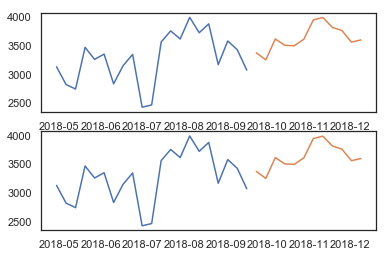

In [21]:
plt.subplot(211)
plt.plot(train_1)
plt.plot(test_1)

plt.subplot(212)
plt.plot(train_1)
plt.plot(test_1)

plt.show()

### Simple Average

In [22]:
train = df['2018-04':'2018-09'].total_calories.resample('D').agg('mean')
test = df['2018-10':'2018-12'].total_calories.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 158
Testing Observations: 67


In [23]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']
yhat.head()

actual  avg_forecast        diff
date                                        
2018-10-01  3180.0   3278.968354  -98.968354
2018-10-02  3162.0   3278.968354 -116.968354
2018-10-03  3584.0   3278.968354  305.031646
2018-10-04  3713.0   3278.968354  434.031646
2018-10-05  3603.0   3278.968354  324.031646

In [24]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

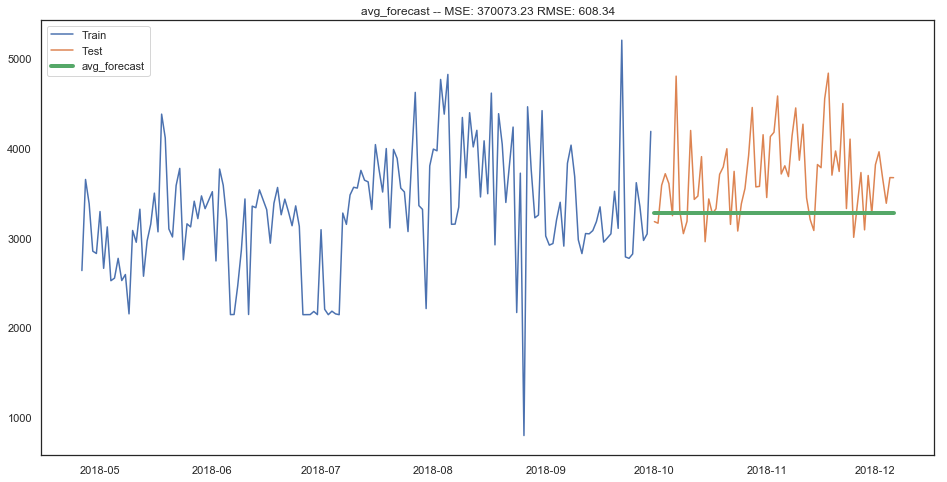

In [25]:
plot_and_eval(yhat.avg_forecast)

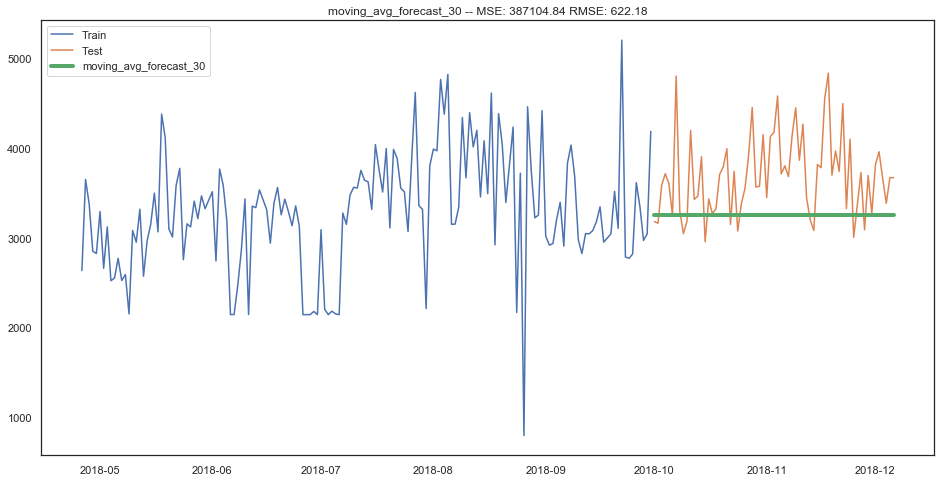

In [26]:
periods = 30
yhat['moving_avg_forecast_30'] = train.rolling(30).mean().iloc[-1]

plot_and_eval(yhat.moving_avg_forecast_30)

In [27]:
yhat.head()

actual  avg_forecast        diff  moving_avg_forecast_30
date                                                                
2018-10-01  3180.0   3278.968354  -98.968354             3258.833333
2018-10-02  3162.0   3278.968354 -116.968354             3258.833333
2018-10-03  3584.0   3278.968354  305.031646             3258.833333
2018-10-04  3713.0   3278.968354  434.031646             3258.833333
2018-10-05  3603.0   3278.968354  324.031646             3258.833333

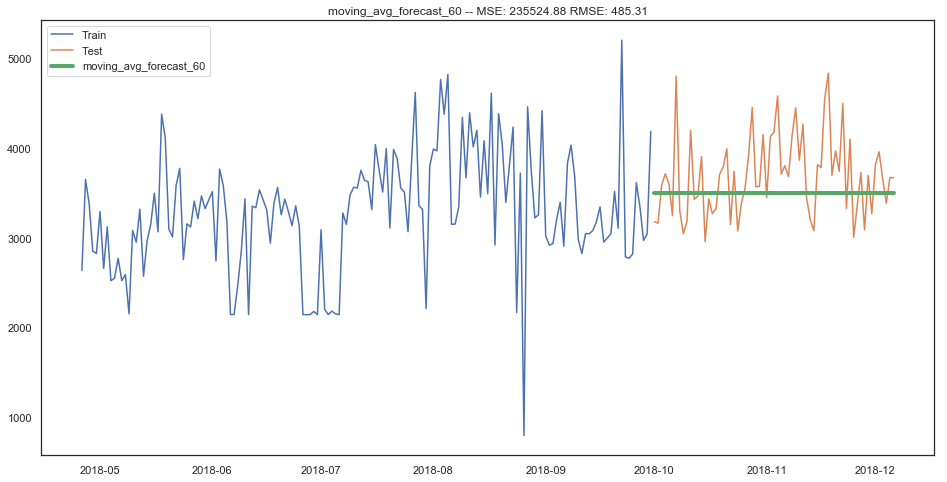

In [28]:
yhat['moving_avg_forecast_60'] = train.rolling(60).mean().iloc[-1]

plot_and_eval(yhat.moving_avg_forecast_60)

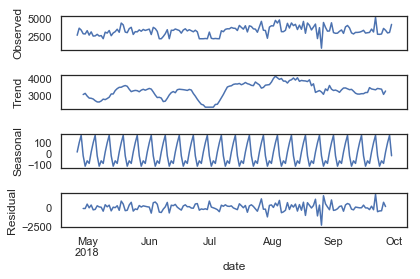

In [29]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

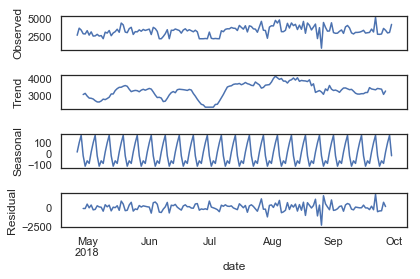

In [30]:
# train = df['2018-04':'2018-09'].total_calories.resample('D').agg('mean')
# test = df['2018-10':'2018-12'].total_calories.resample('D').agg('mean')

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

### Holt's Linear Trend Model

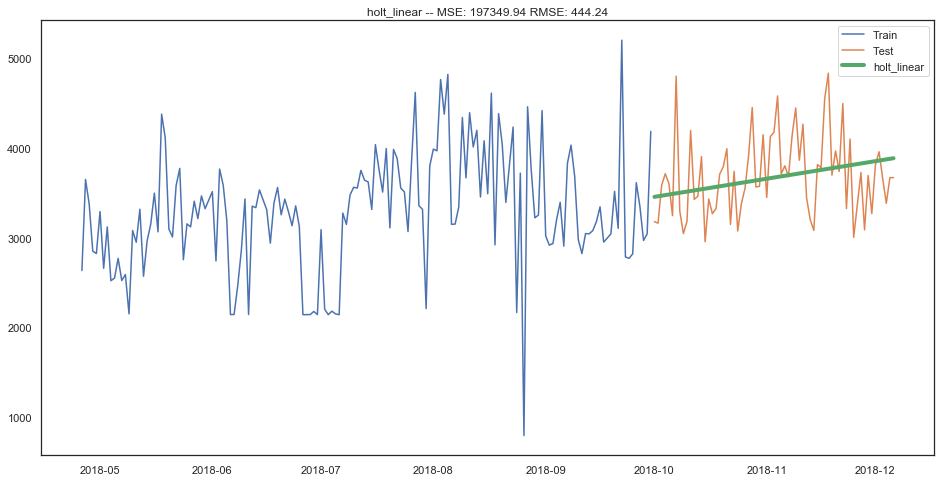

In [31]:
from statsmodels.tsa.api import Holt

holt = Holt(train).fit(smoothing_level=.3, smoothing_slope=.05)

yhat['holt_linear'] = holt.forecast(test.shape[0])

plot_and_eval(yhat.holt_linear)

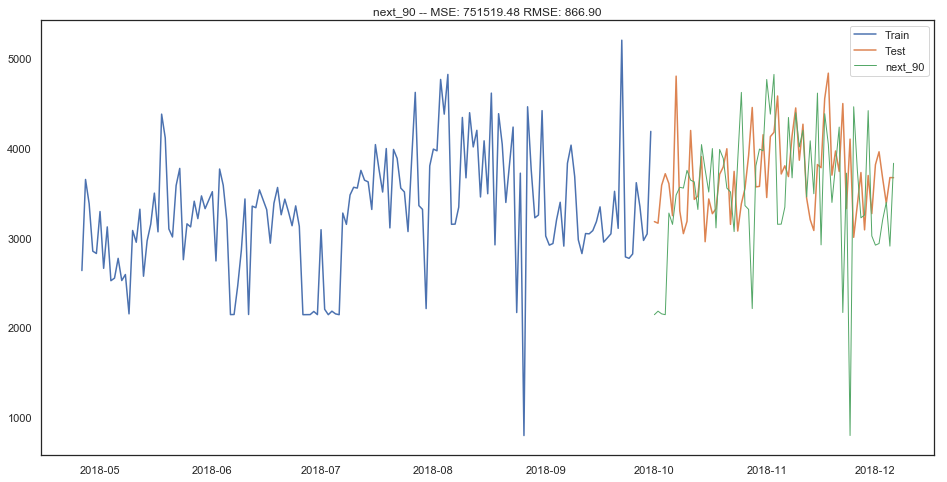

In [32]:
using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

### Prophet Model

In [33]:
df.columns

Index(['activity_calories', 'distance', 'floors', 'mins_active_high',
       'mins_active_light', 'mins_active_med', 'mins_sedentary', 'steps',
       'total_calories'],
      dtype='object')

In [34]:
import seaborn as sns
from fbprophet import Prophet

In [35]:
df.reset_index(inplace=True)
df.head()

date  activity_calories  distance  floors  mins_active_high  \
0 2018-04-26              566.0      1.38     2.0               0.0   
1 2018-04-27             1752.0      4.70    19.0              17.0   
2 2018-04-28             1124.0      1.66     2.0              11.0   
3 2018-04-29              602.0      0.77     0.0               0.0   
4 2018-04-30              540.0      0.62     0.0               0.0   

   mins_active_light  mins_active_med  mins_sedentary   steps  total_calories  
0               93.0              0.0          1347.0  2931.0          2635.0  
1              219.0             46.0          1158.0  9971.0          3649.0  
2              155.0             22.0           702.0  3521.0          3379.0  
3              122.0              0.0           891.0  1639.0          2851.0  
4              104.0              0.0           880.0  1323.0          2825.0

In [36]:
d_df = pd.DataFrame()
d_df['y'] = df.distance
d_df['ds'] = pd.to_datetime(df['date'])

d_df = d_df.groupby(['ds'])['y'].sum().reset_index()

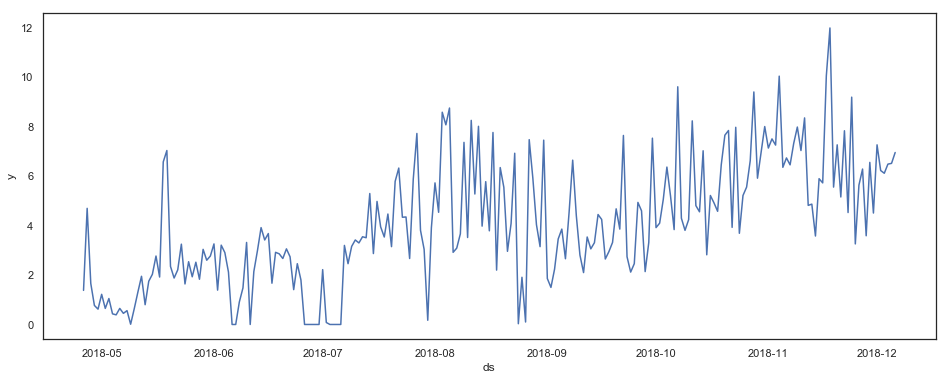

In [37]:
plt.figure(figsize=(16,6))
sns.lineplot(d_df.ds, d_df.y)

In [38]:
d_df.head()

ds     y
0 2018-04-26  1.38
1 2018-04-27  4.70
2 2018-04-28  1.66
3 2018-04-29  0.77
4 2018-04-30  0.62

In [39]:
d_df['cap'] = 11
d_df['floor'] = 1

m = Prophet(daily_seasonality=True, growth='logistic',changepoint_range=0.9)
m.fit(d_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [40]:
future = m.make_future_dataframe(periods=92)
future['cap'] = 11
future['floor'] = 1
print(future.head())
print(future.tail())
print(d_df.tail())

          ds  cap  floor
0 2018-04-26   11      1
1 2018-04-27   11      1
2 2018-04-28   11      1
3 2018-04-29   11      1
4 2018-04-30   11      1
            ds  cap  floor
312 2019-03-04   11      1
313 2019-03-05   11      1
314 2019-03-06   11      1
315 2019-03-07   11      1
316 2019-03-08   11      1
            ds     y  cap  floor
220 2018-12-02  6.23   11      1
221 2018-12-03  6.12   11      1
222 2018-12-04  6.49   11      1
223 2018-12-05  6.52   11      1
224 2018-12-06  6.96   11      1


In [41]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
312 2019-03-04   9.624572    7.295716   11.919282
313 2019-03-05   9.877969    7.468876   12.159291
314 2019-03-06   9.754186    7.472486   12.086614
315 2019-03-07  10.376313    8.038312   12.825146
316 2019-03-08  10.500458    8.123243   12.994413

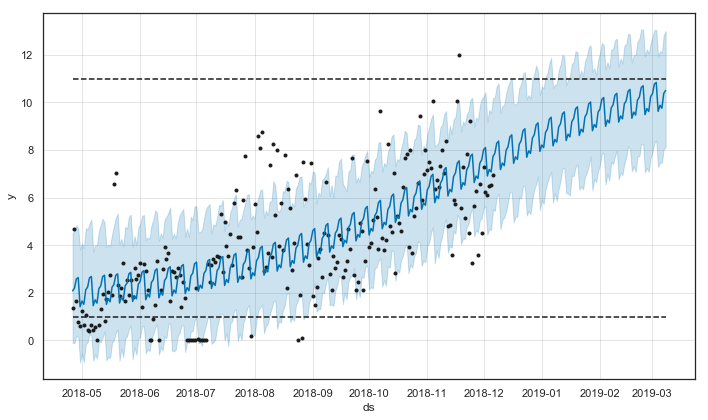

In [42]:
fig1 = m.plot(forecast)

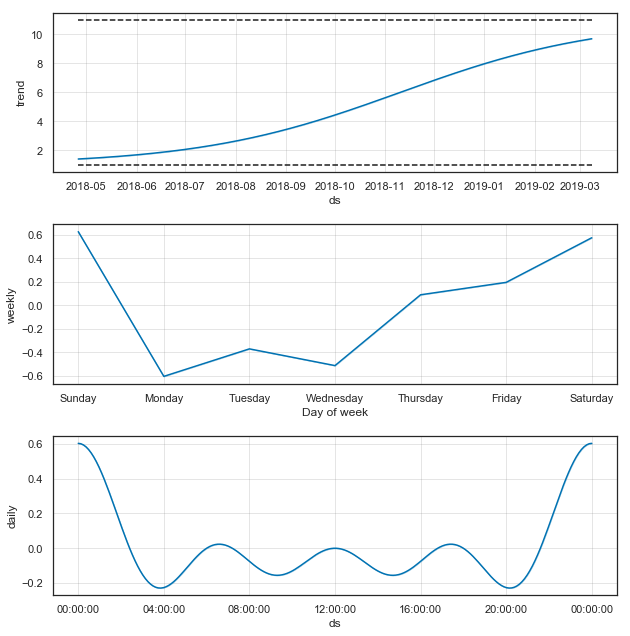

In [43]:
fig2 = m.plot_components(forecast)

In [44]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='30 days')

INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00


In [45]:
df_cv.head(40)

ds      yhat  yhat_lower  yhat_upper     y     cutoff
0  2018-08-09  3.944053    1.845972    6.101679  7.37 2018-08-08
1  2018-08-10  4.864916    2.829812    7.046472  3.52 2018-08-08
2  2018-08-11  4.774947    2.478412    7.117040  8.26 2018-08-08
3  2018-08-12  4.562287    2.676958    6.642335  5.28 2018-08-08
4  2018-08-13  3.714114    1.625156    5.797435  8.02 2018-08-08
5  2018-08-14  4.062342    1.962875    6.117524  3.98 2018-08-08
6  2018-08-15  4.018022    1.904833    6.075943  5.78 2018-08-08
7  2018-08-16  4.257325    2.149846    6.302084  3.79 2018-08-08
8  2018-08-17  5.180847    3.092201    7.327095  7.77 2018-08-08
9  2018-08-18  5.093498    2.993277    7.123578  2.20 2018-08-08
10 2018-08-19  4.883417    2.800556    6.918832  6.35 2018-08-08
11 2018-08-20  4.037781    1.887133    6.191921  5.55 2018-08-08
12 2018-08-21  4.388502    2.298785    6.658220  2.96 2018-08-08
13 2018-08-22  4.346628    2.263062    6.332970  4.09 2018-08-08
14 2018-08-23  4.588330    2.449848    6.647400  6.93 2018-08-08
15 2018-08-24  5.514200    3.404664    7.690292  0.03 2018-08-08
16 2018-08-25  5.429149    3.175371    7.702831  1.91 2018-08-08
17 2018-08-26  5.221311    3.051742    7.358325  0.10 2018-08-08
18 2018-08-27  4.377864    2.205410    6.515145  7.48 2018-08-08
19 2018-08-28  4.730717    2.533638    6.864821  5.93 2018-08-08
20 2018-08-29  4.690917    2.532459    6.727072  4.04 2018-08-08
21 2018-08-30  4.934632    2.832566    7.055730  3.15 2018-08-08
22 2018-08-31  5.862455    3.724969    7.933090  7.46 2018-08-08
23 2018-09-01  5.779292    3.671952    7.982636  1.86 2018-08-08
24 2018-09-02  5.573278    3.344179    7.683119  1.50 2018-08-08
25 2018-09-03  4.731589    2.614384    6.774179  2.24 2018-08-08
26 2018-09-04  5.086131    3.038959    7.013220  3.46 2018-08-08
27 2018-09-05  5.047952    2.938193    7.311305  3.86 2018-08-08
28 2018-09-06  5.293217    3.216675    7.669690  2.66 2018-08-08
29 2018-09-07  6.222517    4.125023    8.423116  4.52 2018-08-08
30 2018-08-24  6.936452    4.751372    9.116178  0.03 2018-08-23
31 2018-08-25  6.800349    4.478721    8.855276  1.91 2018-08-23
32 2018-08-26  6.668738    4.605047    8.882754  0.10 2018-08-23
33 2018-08-27  5.941268    3.757456    7.983929  7.48 2018-08-23
34 2018-08-28  5.871108    3.910778    8.027548  5.93 2018-08-23
35 2018-08-29  6.022108    3.878990    7.990856  4.04 2018-08-23
36 2018-08-30  6.567035    4.462064    8.758780  3.15 2018-08-23
37 2018-08-31  7.463741    5.293762    9.557142  7.46 2018-08-23
38 2018-09-01  7.326431    5.143212    9.496217  1.86 2018-08-23
39 2018-09-02  7.193377    4.906404    9.312207  1.50 2018-08-23

In [46]:
df_p = performance_metrics(df_cv)
df_p.head(40)

horizon       mse      rmse       mae       mape  coverage
92   3 days  9.199670  3.033096  2.413266  14.612035  0.571429
63   4 days  9.030638  3.005102  2.386381  14.654783  0.571429
153  4 days  9.049752  3.008281  2.405419  14.658568  0.571429
33   4 days  6.891114  2.625093  2.149813   3.705741  0.619048
183  4 days  6.560039  2.561257  2.048410   3.693486  0.666667
93   4 days  6.492376  2.548014  2.009671   3.688817  0.666667
3    4 days  6.114498  2.472751  1.905420   3.644769  0.714286
123  4 days  6.231489  2.496295  1.940503   3.642148  0.714286
64   5 days  6.247498  2.499500  1.946201   3.643655  0.714286
154  5 days  5.112944  2.261182  1.727603   3.523885  0.761905
4    5 days  5.835991  2.415780  1.845402   3.525808  0.714286
124  5 days  5.968146  2.442979  1.896371   3.535721  0.714286
94   5 days  6.029595  2.455523  1.944376   3.546681  0.714286
34   5 days  5.882213  2.425327  1.863359   3.525154  0.714286
184  5 days  5.401072  2.324021  1.734621   3.455762  0.761905
65   6 days  3.581367  1.892450  1.527604   0.362360  0.809524
155  6 days  3.897200  1.974133  1.595216   0.359513  0.761905
35   6 days  4.073203  2.018218  1.666632   0.380001  0.761905
125  6 days  4.060560  2.015083  1.663739   0.364955  0.761905
185  6 days  4.211943  2.052302  1.720503   0.377290  0.761905
5    6 days  3.633904  1.906280  1.558469   0.358184  0.809524
95   6 days  4.121541  2.030158  1.627612   0.398599  0.809524
6    7 days  3.879499  1.969644  1.575260   0.348232  0.857143
66   7 days  4.182728  2.045172  1.666563   0.379902  0.809524
36   7 days  4.625986  2.150811  1.756006   0.421762  0.761905
126  7 days  4.616472  2.148598  1.745639   0.420293  0.761905
186  7 days  4.815005  2.194312  1.823159   0.436275  0.761905
96   7 days  5.261385  2.293771  1.938729   0.474907  0.714286
156  7 days  5.074981  2.252772  1.864609   0.466997  0.714286
97   8 days  5.075110  2.252801  1.864653   0.456551  0.714286
67   8 days  5.144433  2.268134  1.909579   0.467702  0.714286
127  8 days  4.775437  2.185277  1.860969   0.497608  0.714286
157  8 days  4.718897  2.172302  1.843856   0.489519  0.714286
37   8 days  4.656568  2.157908  1.789554   0.477699  0.714286
7    8 days  4.666803  2.160278  1.809003   0.483098  0.714286
187  8 days  5.234491  2.287901  1.950636   0.526592  0.666667
158  9 days  5.243355  2.289837  1.952613   0.505476  0.666667
68   9 days  4.875596  2.208075  1.866919   0.504025  0.714286
38   9 days  6.111459  2.472136  2.032839   0.620611  0.666667
128  9 days  5.925461  2.434227  1.971148   0.605948  0.666667

In [47]:
df_p.tail(40)

horizon       mse      rmse       mae      mape  coverage
174 25 days  7.534254  2.744860  2.366405  0.717602  0.571429
54  25 days  8.573700  2.928088  2.543110  0.793177  0.523810
204 25 days  8.204451  2.864341  2.456684  0.757570  0.571429
144 25 days  6.957208  2.637652  2.241660  0.687650  0.619048
84  25 days  6.970978  2.640261  2.245435  0.682319  0.619048
85  26 days  6.892393  2.625337  2.214583  0.681059  0.619048
55  26 days  7.495668  2.737822  2.300383  0.717571  0.619048
115 26 days  7.079780  2.660786  2.235178  0.702158  0.666667
205 26 days  7.265500  2.695459  2.281230  0.710139  0.619048
25  26 days  6.855917  2.618381  2.216625  0.698124  0.619048
145 26 days  6.878910  2.622768  2.242966  0.701554  0.619048
175 26 days  7.234781  2.689755  2.323288  0.707368  0.571429
206 27 days  7.253935  2.693313  2.329927  0.706611  0.571429
26  27 days  6.648385  2.578446  2.220729  0.628651  0.619048
146 27 days  5.963066  2.441939  2.082911  0.591395  0.666667
116 27 days  6.025127  2.454613  2.116529  0.597413  0.666667
56  27 days  6.138388  2.477577  2.130547  0.616367  0.666667
86  27 days  6.113354  2.472520  2.099669  0.611085  0.666667
176 27 days  7.076081  2.660090  2.235824  0.605207  0.619048
27  28 days  6.984996  2.642914  2.205575  0.602216  0.619048
177 28 days  6.209362  2.491859  2.037834  0.477622  0.666667
147 28 days  6.291980  2.508382  2.065486  0.476075  0.666667
117 28 days  5.197487  2.279800  1.844282  0.390823  0.714286
57  28 days  5.663477  2.379806  1.945813  0.416972  0.666667
207 28 days  5.730974  2.393945  1.979640  0.422613  0.666667
87  28 days  5.709531  2.389462  1.973688  0.416889  0.666667
88  29 days  6.057430  2.461185  2.064891  0.443479  0.619048
178 29 days  5.185490  2.277167  1.906631  0.379347  0.666667
148 29 days  4.971287  2.229638  1.850796  0.363281  0.666667
58  29 days  5.895796  2.428126  1.972989  0.406669  0.666667
118 29 days  5.608836  2.368298  1.874649  0.356289  0.714286
208 29 days  5.681344  2.383557  1.908560  0.362176  0.714286
28  29 days  5.566030  2.359244  1.888300  0.394838  0.714286
179 30 days  5.532206  2.352064  1.876079  0.394658  0.714286
29  30 days  5.544314  2.354637  1.879717  0.390215  0.714286
89  30 days  5.953612  2.440002  1.978350  0.398795  0.666667
149 30 days  5.916997  2.432488  1.961730  0.395939  0.666667
59  30 days  5.142629  2.267737  1.815997  0.342897  0.714286
119 30 days  5.627391  2.372212  1.964115  0.380963  0.666667
209 30 days  4.548397  2.132697  1.794905  0.370918  0.714286

#### Wanted to chart the rmse for the number of days out

In [48]:
df_p['hornum'] = df_p['horizon'].astype('str').str[:2].astype('int')

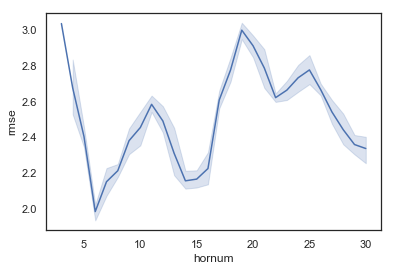

In [49]:
sns.lineplot('hornum', 'rmse', data=df_p)

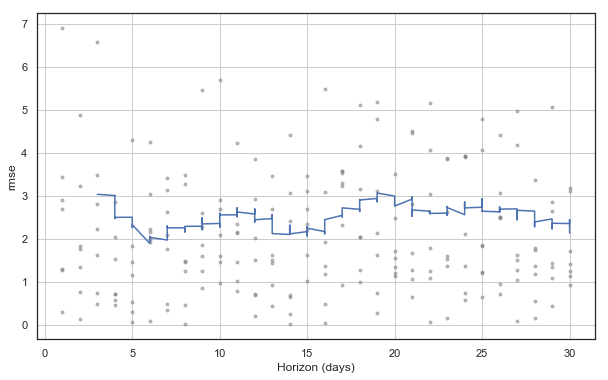

In [50]:
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

# plot_forecast_component(m, forecast, 'yhat')

fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

#### Considered using this to group the data by weekend/weekday

In [51]:
from datetime import timedelta, datetime
import itertools

In [52]:
# df.reset_index('date', inplace=True)

In [53]:
# - Write a function to parse a date column into 6 additional 
# columns (while keeping the original date): year, quarter, month, day of month, day of week, weekend vs. weekday
def add_date_parts(df):
    df = df.copy()
    df['year'] = df.date.dt.year
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['hour'] = df.date.dt.hour
    df['dayofweek'] = df.date.dt.dayofweek
    df['weekday'] = df.date.dt.day_name().str[:3]
    # df['weekday'] = df.date.dt.day_name().str[:3]
    df['is_weekday'] = ((pd.DatetimeIndex(df.date).dayofweek) < 5)
    return df.set_index('date')


# - Create a new dataframe that aggregates the sales_total and 
# sale_amount(item count) using sum and median by day of week.
def aggregate_by_weekday(df):
    df = df.copy()
    by_dayofweek = pd.DataFrame()
    by_dayofweek['quantity_sum'] = df.groupby(['weekday']).quantity.sum()
    by_dayofweek['item_cnt_sum'] = df.groupby(['weekday']).sale_total.sum()
    by_dayofweek['quantity_median'] = df.groupby(['weekday']).quantity.median()
    by_dayofweek['item_cnt_median'] = df.groupby(['weekday']).sale_total.median()
    return by_dayofweek

In [54]:
df = add_date_parts(df)

In [55]:
df.head()

activity_calories  distance  floors  mins_active_high  \
date                                                                
2018-04-26              566.0      1.38     2.0               0.0   
2018-04-27             1752.0      4.70    19.0              17.0   
2018-04-28             1124.0      1.66     2.0              11.0   
2018-04-29              602.0      0.77     0.0               0.0   
2018-04-30              540.0      0.62     0.0               0.0   

            mins_active_light  mins_active_med  mins_sedentary   steps  \
date                                                                     
2018-04-26               93.0              0.0          1347.0  2931.0   
2018-04-27              219.0             46.0          1158.0  9971.0   
2018-04-28              155.0             22.0           702.0  3521.0   
2018-04-29              122.0              0.0           891.0  1639.0   
2018-04-30              104.0              0.0           880.0  1323.0   

            total_calories  year  quarter  month  day  hour  dayofweek  \
date                                                                     
2018-04-26          2635.0  2018        2      4   26     0          3   
2018-04-27          3649.0  2018        2      4   27     0          4   
2018-04-28          3379.0  2018        2      4   28     0          5   
2018-04-29          2851.0  2018        2      4   29     0          6   
2018-04-30          2825.0  2018        2      4   30     0          0   

           weekday  is_weekday  
date                            
2018-04-26     Thu        True  
2018-04-27     Fri        True  
2018-04-28     Sat       False  
2018-04-29     Sun       False  
2018-04-30     Mon        True

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 17 columns):
activity_calories    225 non-null float64
distance             225 non-null float64
floors               225 non-null float64
mins_active_high     225 non-null float64
mins_active_light    225 non-null float64
mins_active_med      225 non-null float64
mins_sedentary       225 non-null float64
steps                225 non-null float64
total_calories       225 non-null float64
year                 225 non-null int64
quarter              225 non-null int64
month                225 non-null int64
day                  225 non-null int64
hour                 225 non-null int64
dayofweek            225 non-null int64
weekday              225 non-null object
is_weekday           225 non-null bool
dtypes: bool(1), float64(9), int64(6), object(1)
memory usage: 30.1+ KB


In [57]:
df.head(20)

activity_calories  distance  floors  mins_active_high  \
date                                                                
2018-04-26              566.0      1.38     2.0               0.0   
2018-04-27             1752.0      4.70    19.0              17.0   
2018-04-28             1124.0      1.66     2.0              11.0   
2018-04-29              602.0      0.77     0.0               0.0   
2018-04-30              540.0      0.62     0.0               0.0   
2018-05-01             1068.0      1.22     0.0               2.0   
2018-05-02              419.0      0.65     0.0               0.0   
2018-05-03             1006.0      1.05     0.0               0.0   
2018-05-04              269.0      0.43     1.0               0.0   
2018-05-05              326.0      0.39     0.0               0.0   
2018-05-06              506.0      0.65     0.0               0.0   
2018-05-07              283.0      0.45     0.0               0.0   
2018-05-08              410.0      0.56     2.0               2.0   
2018-05-09                8.0      0.01     0.0               0.0   
2018-05-10              924.0      0.64     0.0               4.0   
2018-05-11              727.0      1.31     1.0               0.0   
2018-05-12             1113.0      1.95     2.0               7.0   
2018-05-13              394.0      0.80     0.0               0.0   
2018-05-14              794.0      1.75     0.0               0.0   
2018-05-15             1011.0      2.03     0.0               0.0   

            mins_active_light  mins_active_med  mins_sedentary   steps  \
date                                                                     
2018-04-26               93.0              0.0          1347.0  2931.0   
2018-04-27              219.0             46.0          1158.0  9971.0   
2018-04-28              155.0             22.0           702.0  3521.0   
2018-04-29              122.0              0.0           891.0  1639.0   
2018-04-30              104.0              0.0           880.0  1323.0   
2018-05-01              167.0             13.0           919.0  2581.0   
2018-05-02               90.0              0.0           927.0  1372.0   
2018-05-03              157.0             16.0           876.0  2232.0   
2018-05-04               61.0              0.0          1012.0   904.0   
2018-05-05               68.0              0.0           969.0   833.0   
2018-05-06              103.0              0.0           976.0  1383.0   
2018-05-07               63.0              0.0           907.0   952.0   
2018-05-08               53.0             17.0          1221.0  1187.0   
2018-05-09                2.0              0.0          1438.0    21.0   
2018-05-10              136.0              5.0          1295.0  1364.0   
2018-05-11              130.0              0.0           947.0  2771.0   
2018-05-12              184.0              4.0           756.0  4125.0   
2018-05-13               84.0              0.0           895.0  1689.0   
2018-05-14              119.0             19.0           959.0  3710.0   
2018-05-15              183.0              9.0           767.0  4313.0   

            total_calories  year  quarter  month  day  hour  dayofweek  \
date                                                                     
2018-04-26          2635.0  2018        2      4   26     0          3   
2018-04-27          3649.0  2018        2      4   27     0          4   
2018-04-28          3379.0  2018        2      4   28     0          5   
2018-04-29          2851.0  2018        2      4   29     0          6   
2018-04-30          2825.0  2018        2      4   30     0          0   
2018-05-01          3292.0  2018        2      5    1     0          1   
2018-05-02          2660.0  2018        2      5    2     0          2   
2018-05-03          3121.0  2018        2      5    3     0          3   
2018-05-04          2522.0  2018        2      5    4     0          4   
2018-05-05          2551.0  2018        2      5  

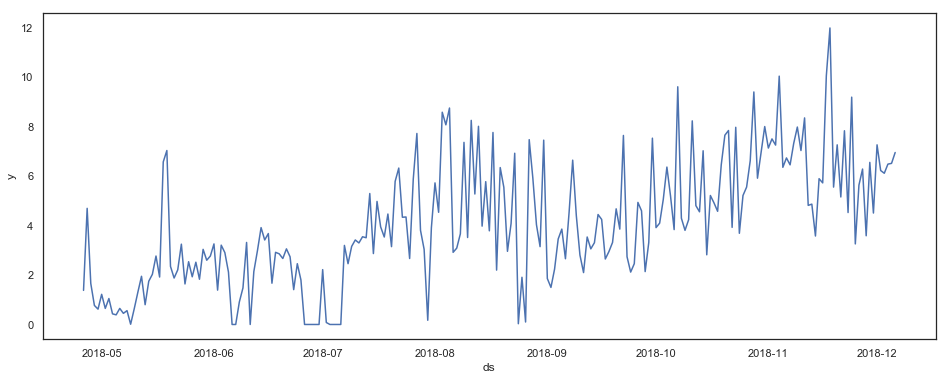

In [58]:
ddf = df[df['dayofweek'].isin([4,5,6])]

ddf.reset_index(inplace=True)
ddf['y'] = ddf.distance
ddf['ds'] = pd.to_datetime(ddf.date)

plt.figure(figsize=(16,6))
sns.lineplot(d_df.ds, d_df.y)

In [59]:
d_df['cap'] = 11
d_df['floor'] = 1

m = Prophet(daily_seasonality=False, growth='logistic', changepoint_range=0.9)
m.fit(d_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [60]:
future = m.make_future_dataframe(periods=22)
future['cap'] = 11
future['floor'] = 1
print(future.head())
print(future.tail())
print(d_df.tail())

          ds  cap  floor
0 2018-04-26   11      1
1 2018-04-27   11      1
2 2018-04-28   11      1
3 2018-04-29   11      1
4 2018-04-30   11      1
            ds  cap  floor
242 2018-12-24   11      1
243 2018-12-25   11      1
244 2018-12-26   11      1
245 2018-12-27   11      1
246 2018-12-28   11      1
            ds     y  cap  floor
220 2018-12-02  6.23   11      1
221 2018-12-03  6.12   11      1
222 2018-12-04  6.49   11      1
223 2018-12-05  6.52   11      1
224 2018-12-06  6.96   11      1


In [61]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
242 2018-12-24  7.759910    5.285843   10.223426
243 2018-12-25  8.019242    5.625815   10.446180
244 2018-12-26  7.907006    5.472467   10.250503
245 2018-12-27  8.544317    6.114058   11.019966
246 2018-12-28  8.680330    6.104839   11.081271

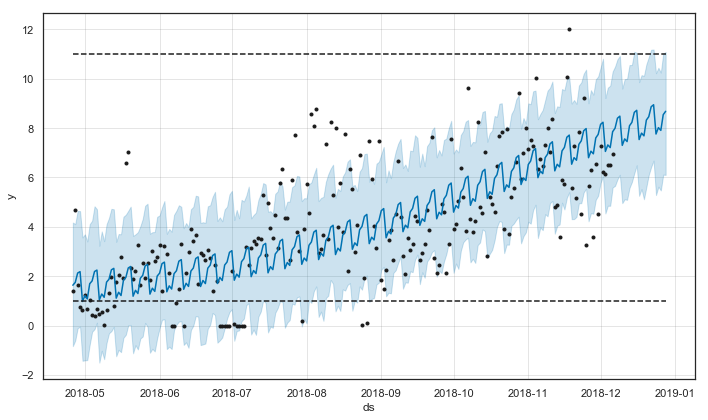

In [62]:
fig1 = m.plot(forecast)

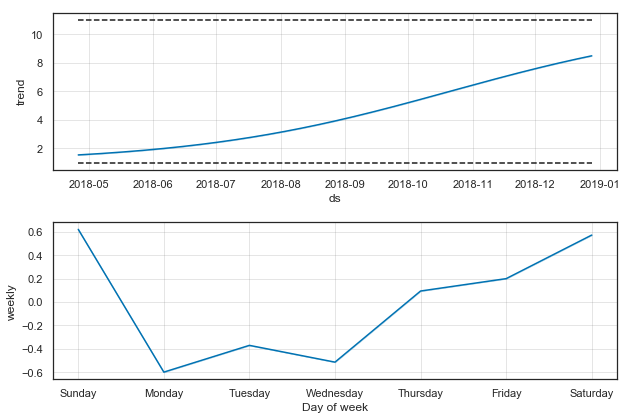

In [63]:
fig2 = m.plot_components(forecast)

In [64]:
df_cv = cross_validation(m, horizon='10 days')


df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 37 forecasts with cutoffs between 2018-05-30 00:00:00 and 2018-11-26 00:00:00


horizon       mse      rmse       mae  mape  coverage
20   1 days  4.498059  2.120863  1.640616   inf  0.756757
171  2 days  5.125205  2.263892  1.758928   inf  0.729730
271  2 days  5.139610  2.267071  1.771429   inf  0.729730
261  2 days  5.343936  2.311695  1.843682   inf  0.729730
241  2 days  5.559607  2.357882  1.911338   inf  0.702703

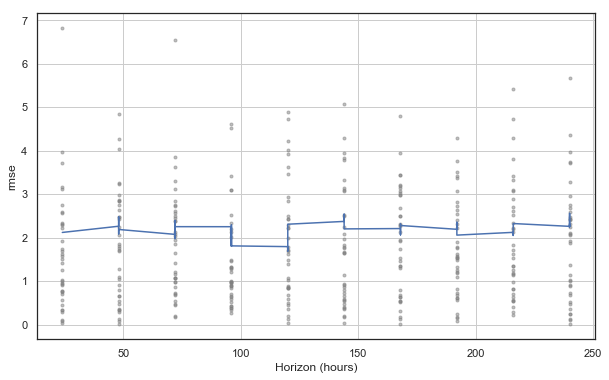

In [65]:
fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

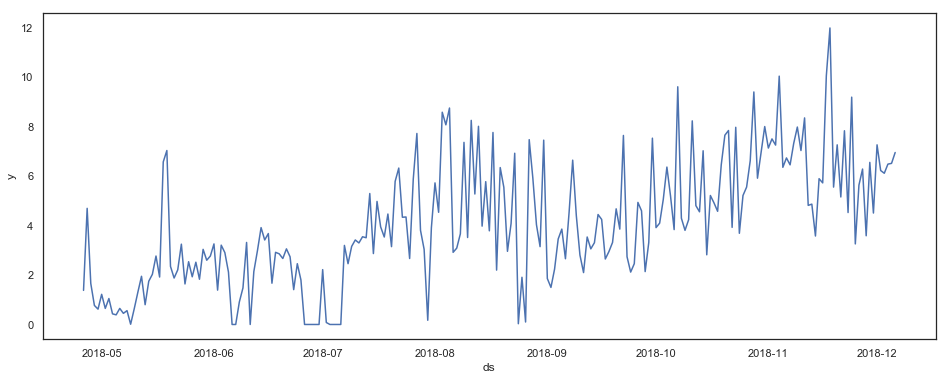

In [66]:
ddf = df[df['dayofweek'].isin([0,1,2,3])]

ddf.reset_index(inplace=True)
ddf['y'] = ddf.distance
ddf['ds'] = pd.to_datetime(ddf.date)

plt.figure(figsize=(16,6))
sns.lineplot(d_df.ds, d_df.y)

In [67]:
ddf['cap'] = 11
ddf['floor'] = 1

m = Prophet(daily_seasonality=False, growth='logistic', changepoint_range=0.9)
m.fit(ddf)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [68]:
future2 = m.make_future_dataframe(periods=22)
future2['cap'] = 11
future2['floor'] = 1
print(future2.head())
print(future2.tail())
print(ddf.tail())

          ds  cap  floor
0 2018-04-26   11      1
1 2018-04-30   11      1
2 2018-05-01   11      1
3 2018-05-02   11      1
4 2018-05-03   11      1
            ds  cap  floor
146 2018-12-24   11      1
147 2018-12-25   11      1
148 2018-12-26   11      1
149 2018-12-27   11      1
150 2018-12-28   11      1
          date  activity_calories  distance  floors  mins_active_high  \
124 2018-11-29             2051.0      6.56    18.0              53.0   
125 2018-12-03             1993.0      6.12     6.0              51.0   
126 2018-12-04             1663.0      6.49    13.0              67.0   
127 2018-12-05             1968.0      6.52    12.0              69.0   
128 2018-12-06             1962.0      6.96     9.0              78.0   

     mins_active_light  mins_active_med  mins_sedentary    steps  \
124              258.0             15.0           717.0  12380.0   
125              219.0             40.0           782.0  12915.0   
126              199.0             11.0      

In [69]:
forecast2 = m.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
242 2018-12-24  7.688019    5.558700    9.737436
243 2018-12-25  7.957562    6.025003   10.080096
244 2018-12-26  7.848347    5.890797    9.788406
245 2018-12-27  8.489791    6.495401   10.430618
246 2018-12-28  7.729351    5.729238    9.769345

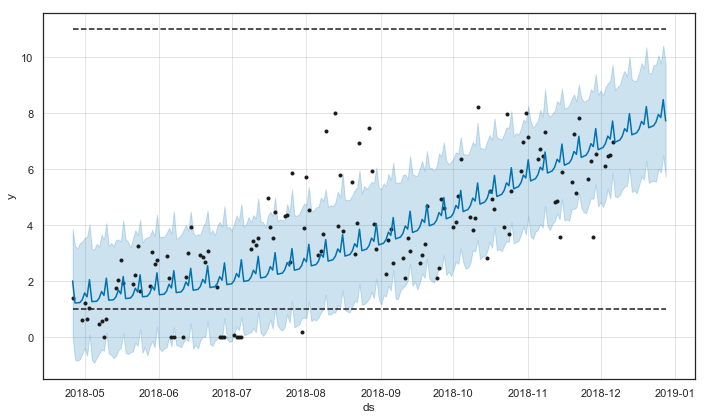

In [70]:
fig2 = m.plot(forecast2)

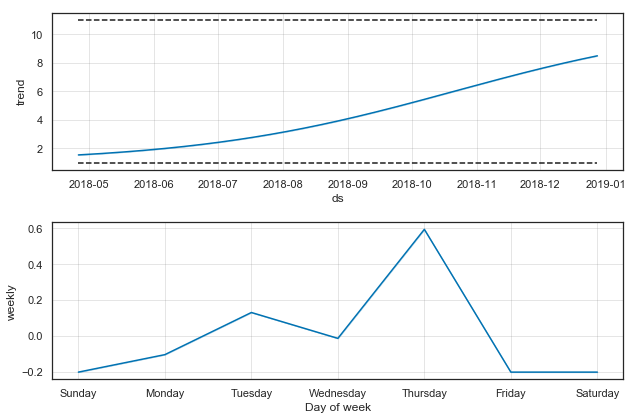

In [71]:
fig2 = m.plot_components(forecast)

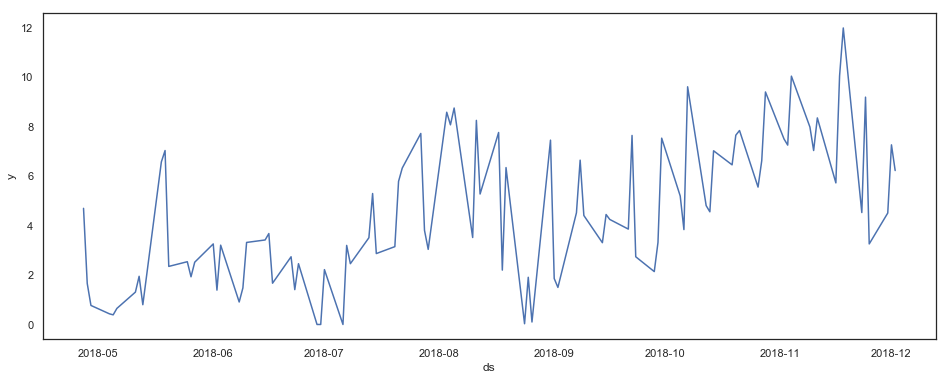

In [72]:
ddf2 = df[df['dayofweek'].isin([4,5,6])]

ddf2.reset_index(inplace=True)
ddf2['y'] = ddf2.distance
ddf2['ds'] = pd.to_datetime(ddf2.date)

plt.figure(figsize=(16,6))
sns.lineplot(ddf2.ds, ddf2.y)

In [73]:
ddf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 20 columns):
date                 96 non-null datetime64[ns]
activity_calories    96 non-null float64
distance             96 non-null float64
floors               96 non-null float64
mins_active_high     96 non-null float64
mins_active_light    96 non-null float64
mins_active_med      96 non-null float64
mins_sedentary       96 non-null float64
steps                96 non-null float64
total_calories       96 non-null float64
year                 96 non-null int64
quarter              96 non-null int64
month                96 non-null int64
day                  96 non-null int64
hour                 96 non-null int64
dayofweek            96 non-null int64
weekday              96 non-null object
is_weekday           96 non-null bool
y                    96 non-null float64
ds                   96 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(10), int64(6), object(1)
memory usa

In [74]:
ddf.set_index('date', inplace=True)
ddf2.set_index('date', inplace=True)

In [75]:
train = ddf['2018-07-15':'2018-10'].distance.resample('D').agg('mean')
test = ddf['2018-11':'2018-12'].distance.resample('D').agg('mean')

train2 = ddf2['2018-07-15':'2018-10'].distance.resample('D').agg('mean')
test2 = ddf2['2018-11':'2018-12'].distance.resample('D').agg('mean')

print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 144
Training Observations: 108
Testing Observations: 36


Graphed the two predictions together, but the line graphs did not connect (which makes sense). So we decided not to use the weekend/weekday features.

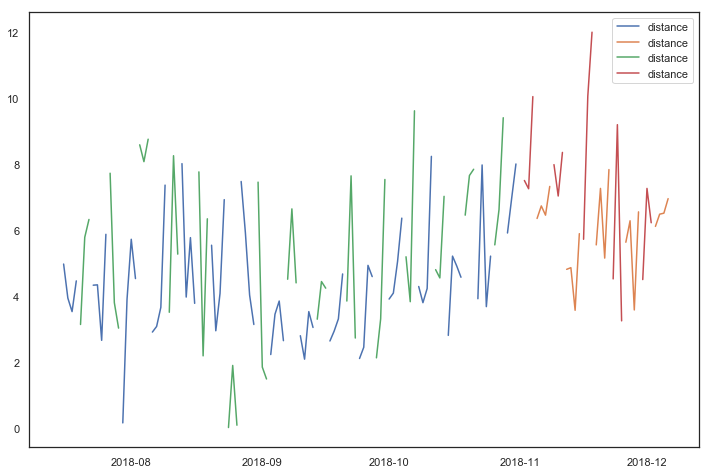

In [76]:
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.plot(train2)
plt.plot(test2)
plt.legend()
plt.show()

Holt's Linear Trend on Distance

In [77]:
ts_data = df.distance.resample('D').agg('sum')

train_size = int(len(ts_data) * 0.85)
train_1, test_1 = ts_data[0:train_size], ts_data[train_size:len(ts_data)]
print('Observations: %d' % (len(ts_data)))
print('Training Observations: %d' % (len(train_1)))
print('Testing Observations: %d' % (len(test_1)))

Observations: 225
Training Observations: 191
Testing Observations: 34


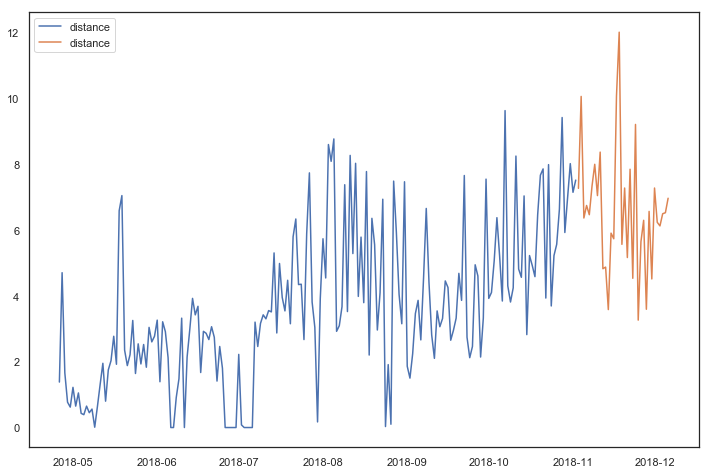

In [78]:
plt.figure(figsize=(12, 8))
plt.plot(train_1)
plt.plot(test_1)
plt.legend()
plt.show()

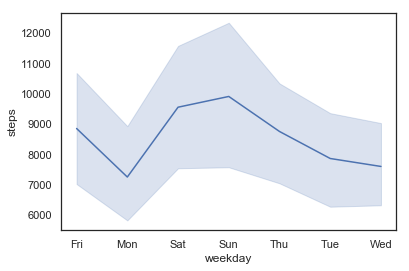

In [79]:
sns.lineplot(df.weekday, df.steps)

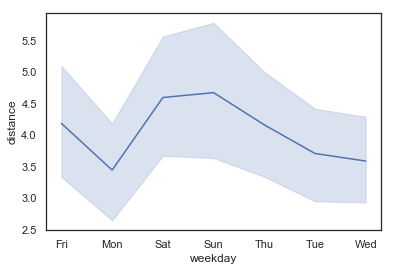

In [80]:
sns.lineplot(df.weekday, df.distance)

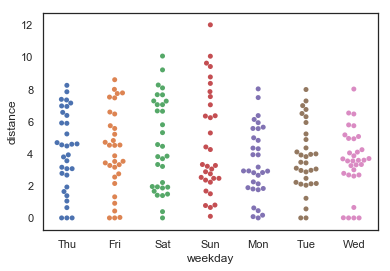

In [81]:
sns.swarmplot(df.weekday, df.distance)

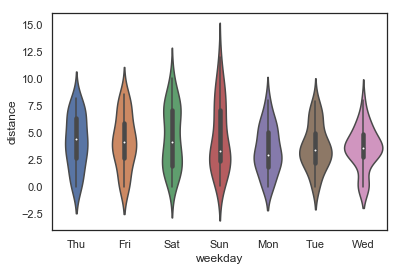

In [82]:
sns.violinplot(df.weekday, df.distance)

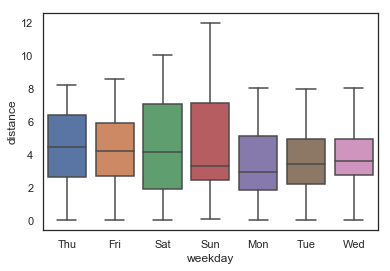

In [83]:
sns.boxplot(df.weekday, df.distance)

# Looping through the features using Prophet
Put the import here to make restarting my kernal easier.

In [84]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from proj_acquire import *
from proj_prepare import *

import zgulde.extend_pandas as ep
import seaborn as sns
from statsmodels.tsa.api import Holt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

In [85]:
df = prepare_fitbit()

In [86]:
df.tail(23) # missing 2018-12-07 through 2018-12-28

index activity_calories distance floors mins_active_high  \
224 2018-12-06             1,962     6.96      9               78   
225 2018-12-07               NaN      NaN    NaN              NaN   
226 2018-12-08               NaN      NaN    NaN              NaN   
227 2018-12-09               NaN      NaN    NaN              NaN   
228 2018-12-10               NaN      NaN    NaN              NaN   
229 2018-12-11               NaN      NaN    NaN              NaN   
230 2018-12-12               NaN      NaN    NaN              NaN   
231 2018-12-13               NaN      NaN    NaN              NaN   
232 2018-12-14               NaN      NaN    NaN              NaN   
233 2018-12-15               NaN      NaN    NaN              NaN   
234 2018-12-16               NaN      NaN    NaN              NaN   
235 2018-12-17               NaN      NaN    NaN              NaN   
236 2018-12-18               NaN      NaN    NaN              NaN   
237 2018-12-19               NaN      NaN    NaN              NaN   
238 2018-12-20               NaN      NaN    NaN              NaN   
239 2018-12-21               NaN      NaN    NaN              NaN   
240 2018-12-22               NaN      NaN    NaN              NaN   
241 2018-12-23               NaN      NaN    NaN              NaN   
242 2018-12-24               NaN      NaN    NaN              NaN   
243 2018-12-25               NaN      NaN    NaN              NaN   
244 2018-12-26               NaN      NaN    NaN              NaN   
245 2018-12-27               NaN      NaN    NaN              NaN   
246 2018-12-28               NaN      NaN    NaN              NaN   

    mins_active_light mins_active_med mins_sedentary   steps total_calories  \
224               198               4            647  14,774          3,669   
225               NaN             NaN            NaN     NaN            NaN   
226               NaN             NaN            NaN     NaN            NaN   
227               NaN             NaN            NaN     NaN            NaN   
228               NaN             NaN            NaN     NaN            NaN   
229               NaN             NaN            NaN     NaN            NaN   
230               NaN             NaN            NaN     NaN            NaN   
231               NaN             NaN            NaN     NaN            NaN   
232               NaN             NaN            NaN     NaN            NaN   
233               NaN             NaN            NaN     NaN            NaN   
234               NaN             NaN            NaN     NaN            NaN   
235               NaN             NaN            NaN     NaN            NaN   
236               NaN             NaN            NaN     NaN            NaN   
237               NaN             NaN            NaN     NaN            NaN   
238               NaN             NaN            NaN     NaN            NaN   
239               NaN             NaN            NaN     NaN            NaN   
240               NaN             NaN            NaN     NaN            NaN   
241               NaN             NaN            NaN     NaN            NaN   
242               NaN             NaN            NaN     NaN            NaN   
243               NaN             NaN            NaN     NaN            NaN   
244               NaN             NaN            NaN     NaN            NaN   
245               NaN             NaN            NaN     NaN            NaN   
246               NaN             NaN            NaN     NaN            NaN   

    calories carbs  fat fiber protien sodium    water  
224        0   0 g  0 g   0 g     0 g   0 mg  0 fl oz  
225        0   0 g  0 g   0 g     0 g   0 mg  0 fl oz  
226        0   0 g  0 g   0 g     0 g   0 mg  0 fl oz  
227        0   0 g  0 g   0 g     0 g   0 mg  0 fl oz  
228        0   0 g  0 g   0 g     0 g   0 mg  0 fl oz  
229        0   0 g  0 g   0 g     0 g   0 mg  0 fl oz  
230        0   0 g  0 g   0 g     0 g   0 mg  0 fl oz  
231    

In [87]:
# rename index to date
df.rename(columns={'index': 'date'}, inplace=True)

# # set date to index
df.set_index('date', inplace=True)

# dropping columns with mostly zero information
to_drop = ['calories', 'carbs', 'fat', 'fiber',
       'protien', 'sodium', 'water']
df = df.drop(columns=(to_drop))

# remove commas and convert to float64
for col in df:
    df[col] = df[col].str.replace(',', '')
    df[col] = df[col].astype('float64')

# drop NaN rows as we'll be predicting them anyway
df.dropna(inplace=True)

In [88]:
df.reset_index(inplace=True)
df.head(3)

date  activity_calories  distance  floors  mins_active_high  \
0 2018-04-26              566.0      1.38     2.0               0.0   
1 2018-04-27             1752.0      4.70    19.0              17.0   
2 2018-04-28             1124.0      1.66     2.0              11.0   

   mins_active_light  mins_active_med  mins_sedentary   steps  total_calories  
0               93.0              0.0          1347.0  2931.0          2635.0  
1              219.0             46.0          1158.0  9971.0          3649.0  
2              155.0             22.0           702.0  3521.0          3379.0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Results for the  activity_calories  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  activity_calories sorted by rmse:
    horizon            mse        rmse         mae      mape  coverage  \
49  20 days  952266.013211  975.841182  859.964891  2.372345  0.523810   
169 20 days  946705.337082  972.987840  856.606647  2.349765  0.571429   
17  18 days  936006.446986  967.474262  805.730720  5.098086  0.619048   

     median  diff_of_rmse_&_median  percent_diff  
49   1481.0             505.158818      0.341093  
169  1481.0             508.012160      0.343020  
17   1481.0             513.525738      0.346743  
median of percent diff for  activity_calories :  0.47146093275004286
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  distance  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  distance sorted by rmse:
    horizon       mse      rmse       mae       mape  coverage  median  \
92   3 days  8.289575  2.879162  2.200756  13.803520  0.619048    3.68   
153  4 days  7.949251  2.819442  2.148786  13.837355  0.619048    3.68   
63   4 days  7.948827  2.819366  2.145611  13.836744  0.619048    3.68   

     diff_of_rmse_&_median  percent_diff  
92                0.800838      0.217619  
153               0.860558      0.233847  
63                0.860634      0.233868  
median of percent diff for  distance :  0.3589062085624734
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  floors  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  floors sorted by rmse:
    horizon         mse       rmse        mae  mape  coverage  median  \
153  4 days  618.404741  24.867745  12.879156   inf  0.761905     7.0   
92   3 days  625.125666  25.002513  13.078614   inf  0.761905     7.0   
63   4 days  627.407004  25.048094  13.300565   inf  0.761905     7.0   

     diff_of_rmse_&_median  percent_diff  
153              17.867745      2.552535  
92               18.002513      2.571788  
63               18.048094      2.578299  
median of percent diff for  floors :  2.5717875991972394
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  mins_active_high  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  mins_active_high sorted by rmse:
    horizon          mse       rmse        mae  mape  coverage  median  \
63   4 days  2096.626224  45.788931  39.734286   inf   0.47619    15.0   
153  4 days  2101.995053  45.847520  40.236534   inf   0.47619    15.0   
92   3 days  2137.851574  46.236907  40.150648   inf   0.47619    15.0   

     diff_of_rmse_&_median  percent_diff  
63               30.788931      2.052595  
153              30.847520      2.056501  
92               31.236907      2.082460  
median of percent diff for  mins_active_high :  2.0565013066535665
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  mins_active_light  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  mins_active_light sorted by rmse:
    horizon           mse        rmse        mae      mape  coverage  median  \
137 18 days  12046.680511  109.757371  83.381190  3.068490  0.714286   203.0   
17  18 days  11996.790841  109.529863  82.720135  3.067737  0.714286   203.0   
138 19 days  11886.658846  109.025955  81.544624  3.063733  0.714286   203.0   

     diff_of_rmse_&_median  percent_diff  
137              93.242629      0.459323  
17               93.470137      0.460444  
138              93.974045      0.462926  
median of percent diff for  mins_active_light :  0.6757664804073794
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  mins_active_med  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  mins_active_med sorted by rmse:
    horizon         mse       rmse        mae  mape  coverage  median  \
92   3 days  281.744197  16.785237  13.542407   inf  0.714286    11.0   
153  4 days  285.667298  16.901695  13.727689   inf  0.714286    11.0   
63   4 days  288.567716  16.987281  13.809361   inf  0.714286    11.0   

     diff_of_rmse_&_median  percent_diff  
92                5.785237      0.525931  
153               5.901695      0.536518  
63                5.987281      0.544298  
median of percent diff for  mins_active_med :  0.5365177395119702
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  mins_sedentary  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  mins_sedentary sorted by rmse:
    horizon           mse        rmse         mae      mape  coverage  median  \
92   3 days  53569.521114  231.450904  168.763731  1.277278  0.904762   750.0   
63   4 days  51203.551193  226.282017  161.099270  1.271243  0.904762   750.0   
153  4 days  50679.467155  225.121006  159.228671  1.264682  0.904762   750.0   

     diff_of_rmse_&_median  percent_diff  
92              518.549096      0.691399  
63              523.717983      0.698291  
153             524.878994      0.699839  
median of percent diff for  mins_sedentary :  0.8238231870151846
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  steps  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Top of performance metrics for  steps sorted by rmse:
    horizon           mse         rmse          mae       mape  coverage  \
92   3 days  4.051571e+07  6365.195519  4928.057992  13.247295  0.571429   
153  4 days  3.903020e+07  6247.415592  4824.507927  13.282362  0.571429   
63   4 days  3.902764e+07  6247.210936  4815.247576  13.281554  0.571429   

     median  diff_of_rmse_&_median  percent_diff  
92   7806.0            1440.804481      0.184577  
153  7806.0            1558.584408      0.199665  
63   7806.0            1558.789064      0.199691  
median of percent diff for  steps :  0.33848712409567727
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Results for the  total_calories  feature:


INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00


Top of performance metrics for  total_calories sorted by rmse:
    horizon            mse        rmse         mae      mape  coverage  \
17  18 days  894413.677851  945.734465  720.193944  0.358760  0.666667   
137 18 days  874627.177441  935.215043  702.722951  0.355720  0.714286   
63   4 days  871966.091873  933.791246  644.554752  0.350502  0.666667   

     median  diff_of_rmse_&_median  percent_diff  
17   3385.0            2439.265535      0.720610  
137  3385.0            2449.784957      0.723718  
63   3385.0            2451.208754      0.724138  
median of percent diff for  total_calories :  0.8271041477414698
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

['activity_calories', 'distance', 'floors', 'mins_active_high', 'mins_active_light', 'mins_active_med', 'mins_sedentary', 'steps', 'total_calories']
[0.47146093275004286, 0.3589062085624734, 2.5717875991972394, 2.0565013066535665, 0.6757664804073794, 0.5365177395119702, 0.8238231870151846, 0.33848712409567727, 0.82710

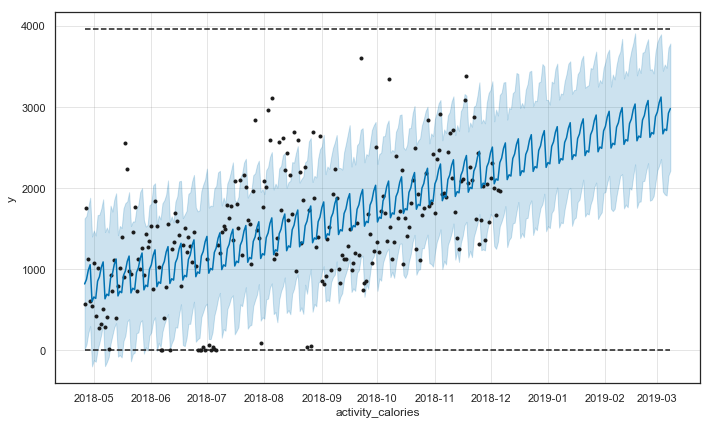

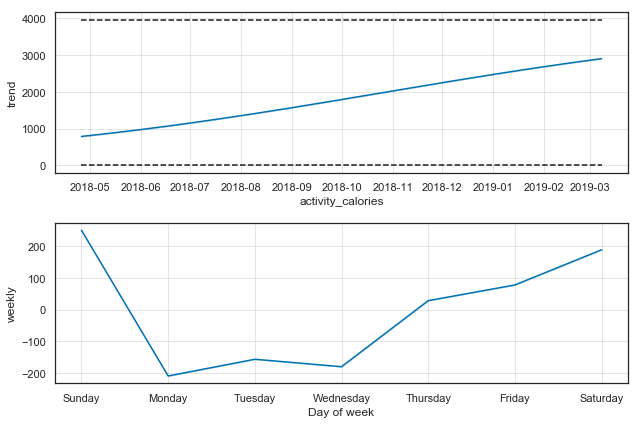

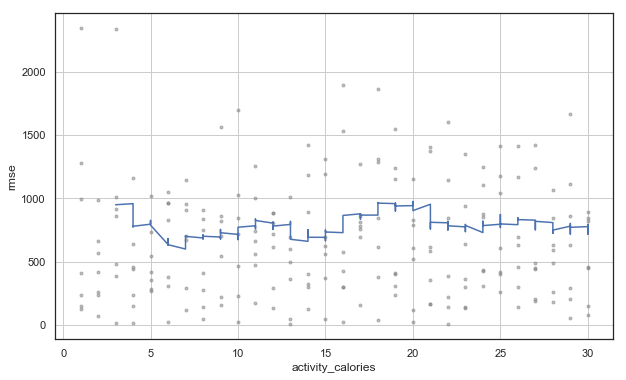

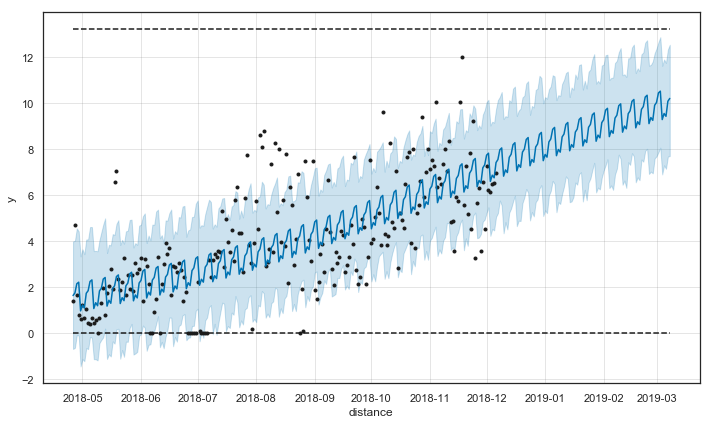

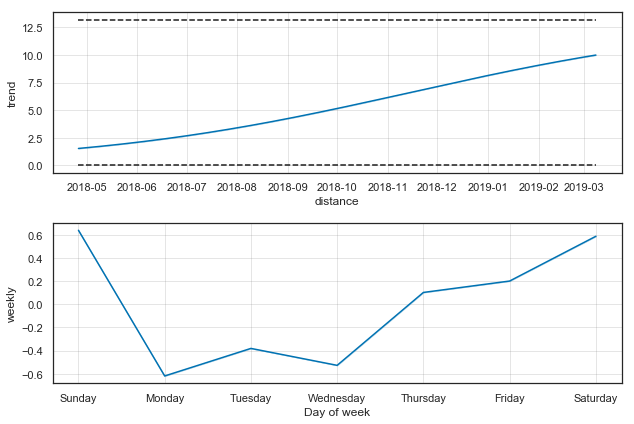

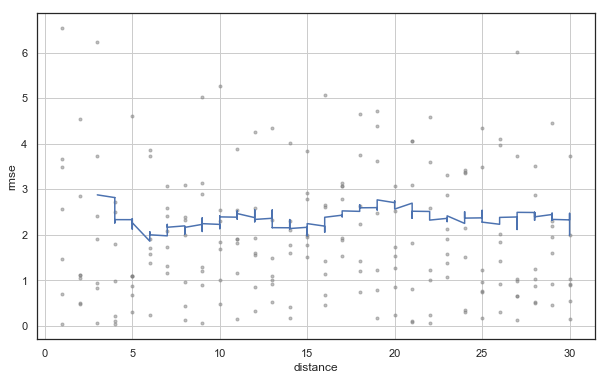

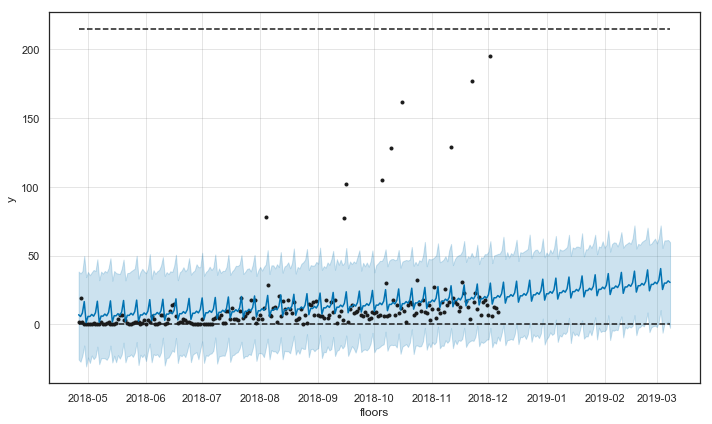

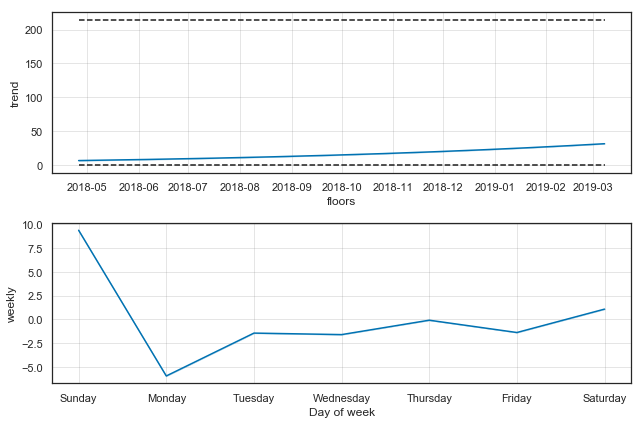

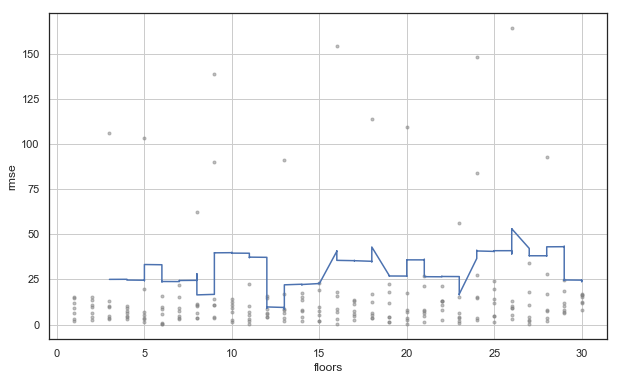

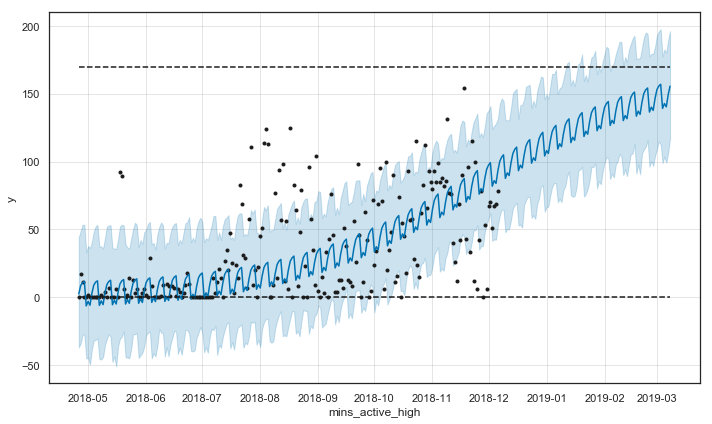

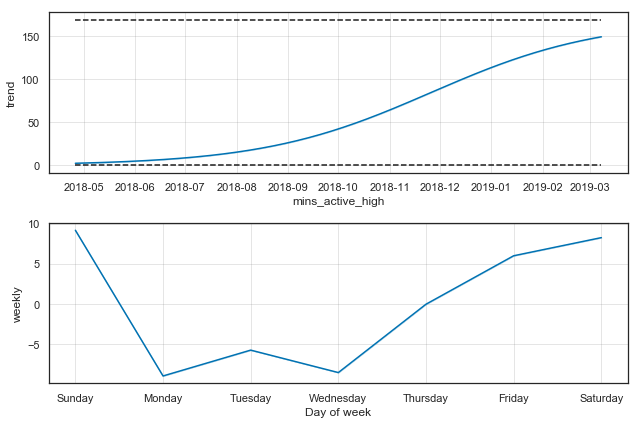

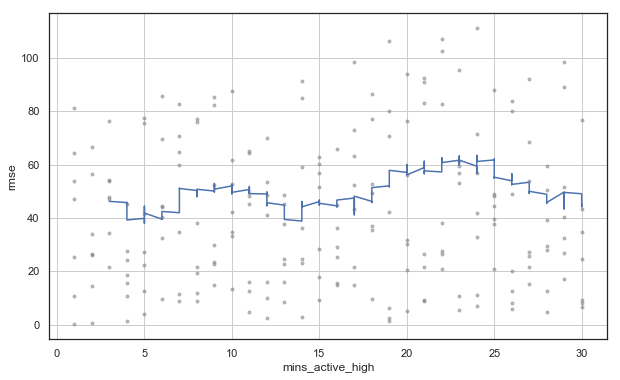

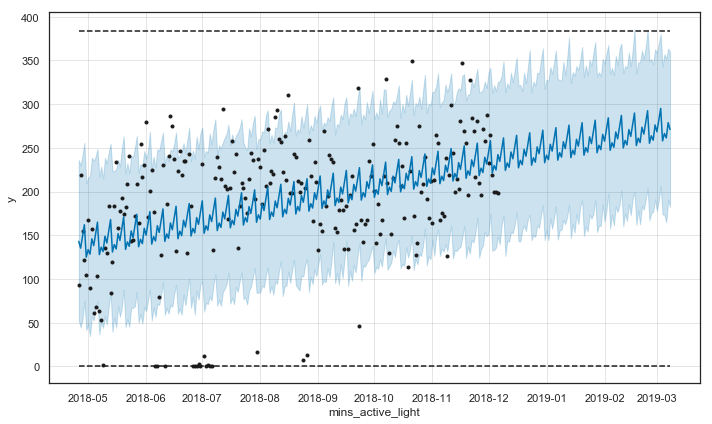

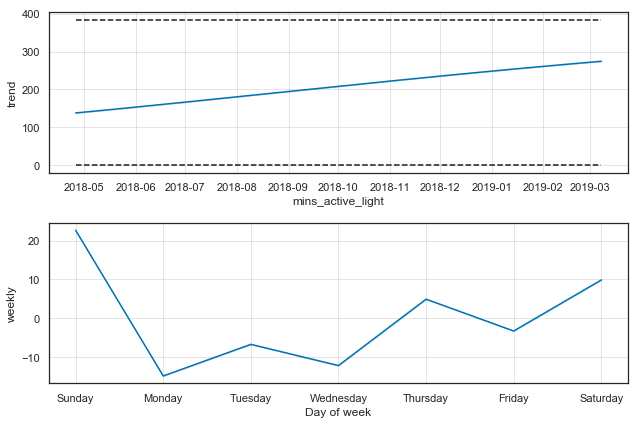

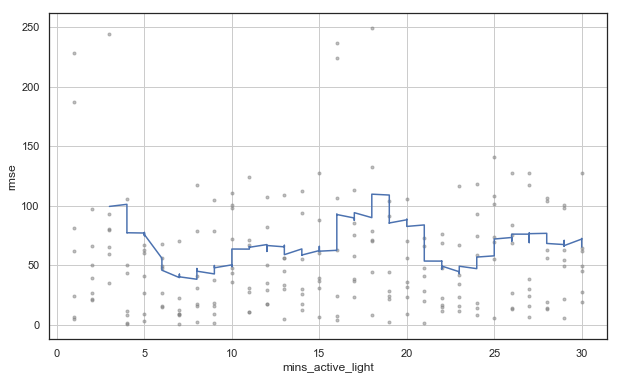

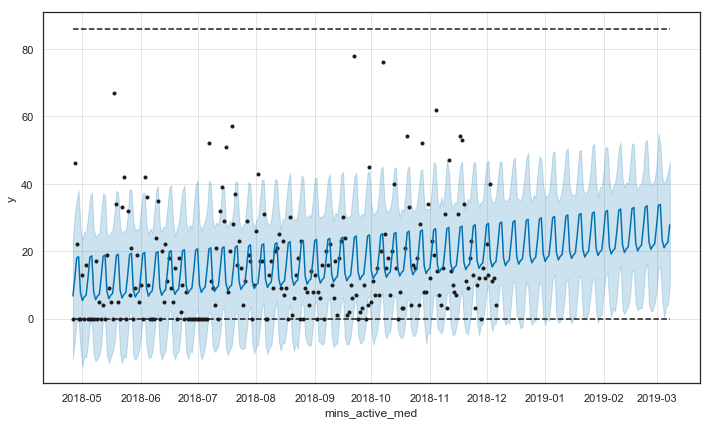

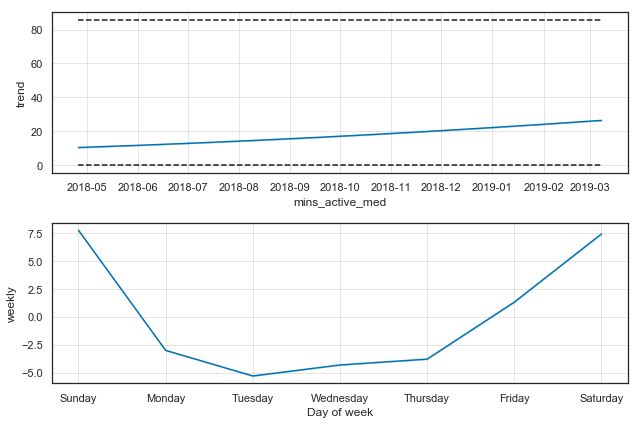

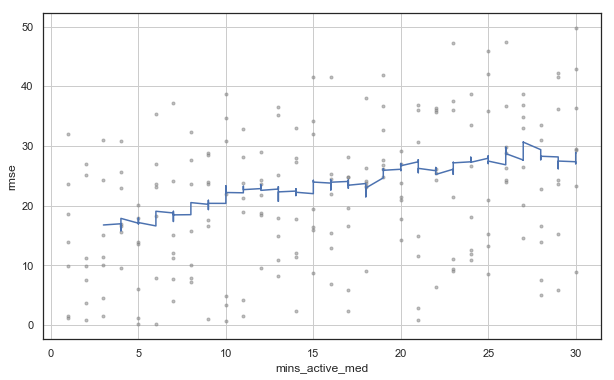

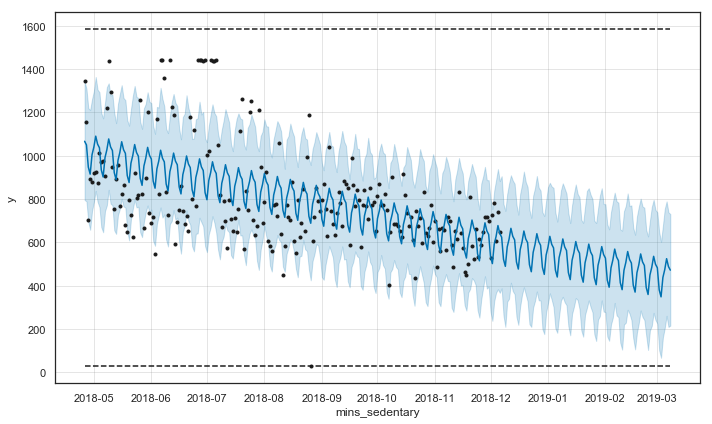

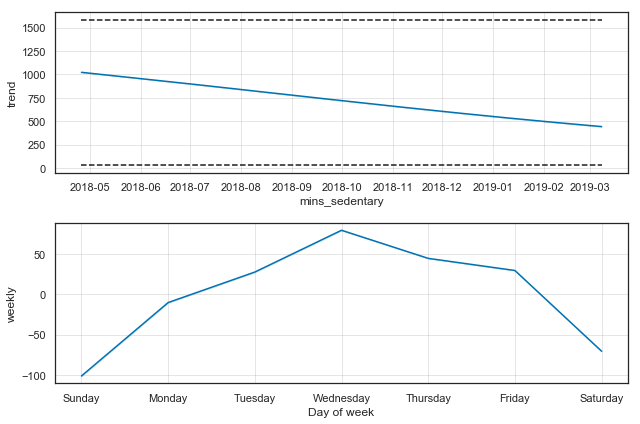

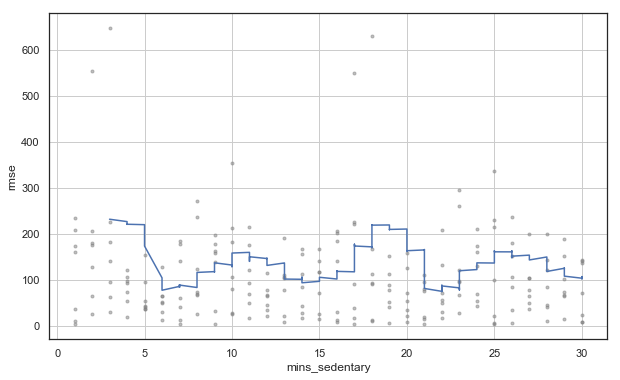

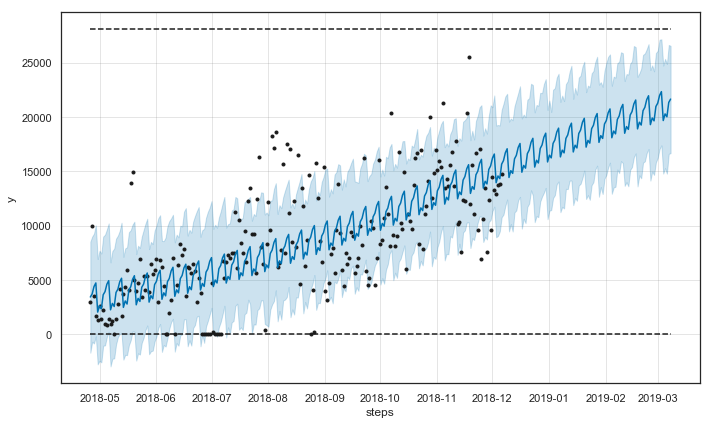

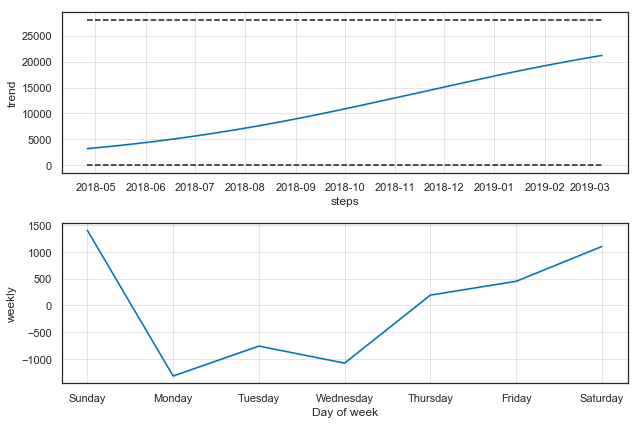

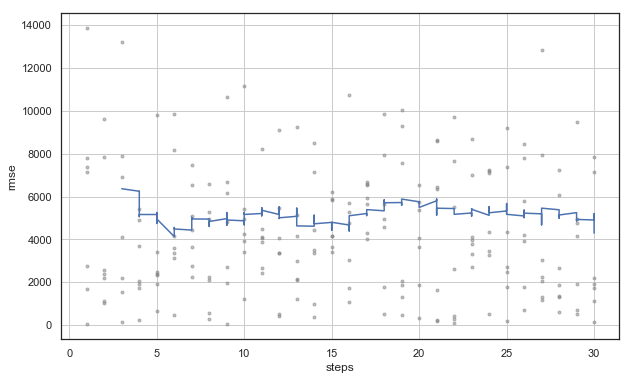

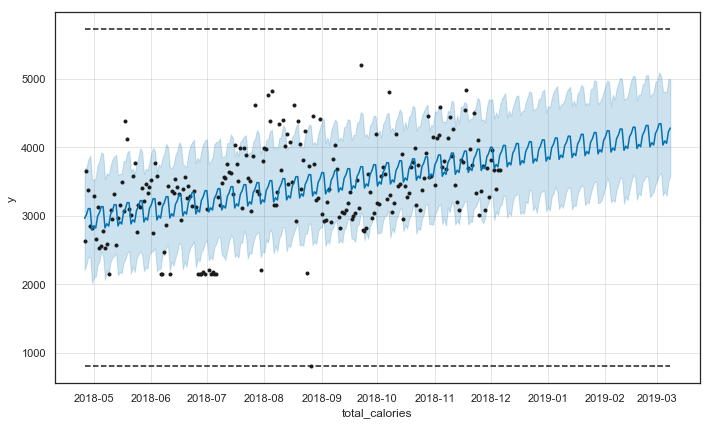

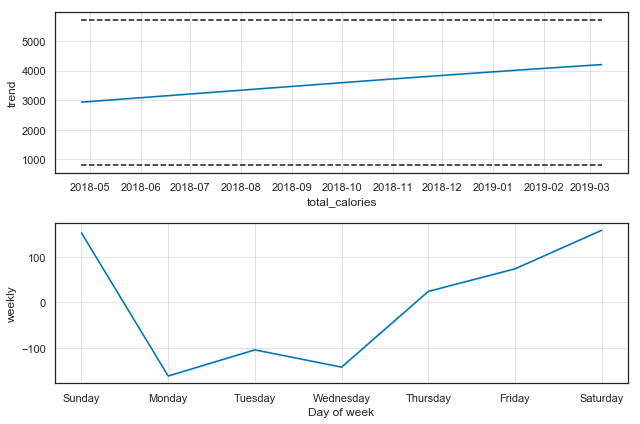

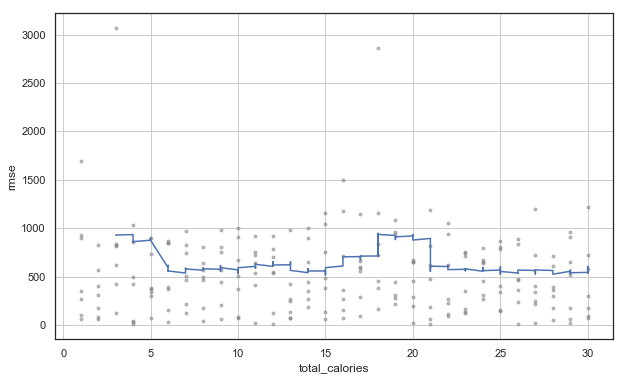

In [89]:
df_col = ['activity_calories', 'distance', 'floors', 'mins_active_high',
       'mins_active_light', 'mins_active_med', 'mins_sedentary', 'steps',
       'total_calories']
ranked_features = []

for col in df_col:
    print('Results for the ', col, ' feature:')
    d_df = pd.DataFrame()
    d_df['y'] = df[col]
    d_df['ds'] = pd.to_datetime(df['date'])

    d_df = d_df.groupby(['ds'])['y'].sum().reset_index()

    d_df['cap'] = d_df.y.max() * 1.1
    d_df['floor'] = d_df.y.min()

    m = Prophet(daily_seasonality=False, growth='logistic',changepoint_range=0.9)
    m.fit(d_df)

    future = m.make_future_dataframe(periods=92)
    future['cap'] = d_df.y.max() * 1.1
    future['floor'] = d_df.y.min()

    forecast = m.predict(future)

#     fig1 = m.plot(forecast)
    components_fig = m.plot(forecast)
    axes = components_fig.get_axes()
    axes[0].set_xlabel(col)

#     fig2 = m.plot_components(forecast)
    components_fig = m.plot_components(forecast)
    axes = components_fig.get_axes()
    axes[0].set_xlabel(col)

    
    df_cv = cross_validation(m, horizon='30 days')
    df_p = performance_metrics(df_cv)

#     fig3 = plot_cross_validation_metric(df_cv, metric='rmse')
    components_fig = plot_cross_validation_metric(df_cv, metric='rmse')
    axes = components_fig.get_axes()
    axes[0].set_xlabel(col)

    
    print('Top of performance metrics for ', col, 'sorted by rmse:')
    df_p['median'] = df[col].median()
    df_p['diff_of_rmse_&_median'] = abs(df_p['rmse'] - df[col].median())
    df_p['percent_diff'] = df_p['diff_of_rmse_&_median'] / df_p['median']
    print(df_p.sort_values(by='diff_of_rmse_&_median', ascending=True).head(3))
    print('median of percent diff for ', col, ': ', df_p['percent_diff'].median())
    ranked_features.append(df_p['percent_diff'].median())
 

#     df_p['horizon_num'] = df_p['horizon'].astype('str').str[:2].astype('int')
#     print('for feature: ', col)
#     sns.lineplot('horizon_num', 'rmse', data=df_p)
    
#     components_fig = sns.lineplot('horizon_num', 'rmse', data=df_p)
#     axes = components_fig.get_axes()
#     axes[0].set_xlabel(col)

#     df_p.drop(columns=['horizon_num'], inplace=True)

    
    print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
    print()

print(df_col)
print(ranked_features)

Using Prophet to predict the missing values, we get 
abs(df_p['rmse'] - df[col].median())/ df_p['median'] per feature:

- steps------------------ 0.33848712409567727
- distance--------------- 0.3589062085624734
- activity_calories------ 0.47146093275004286
- mins_active_med-------- 0.5365177395119702
- mins_active_light------ 0.6757664804073794
- mins_sedentary--------- 0.8238231870151846
- total_calories--------- 0.8271041477414698
- mins_active_high------- 2.0565013066535665
- floors----------------- 2.5717875991972394

for feature:  total_calories


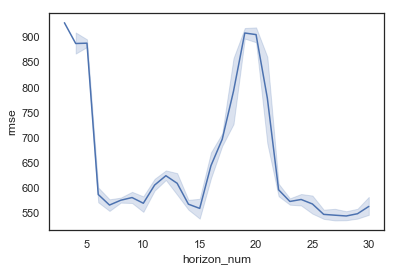

In [90]:
# for last feature run, total_calories...

df_p['horizon_num'] = df_p['horizon'].astype('str').str[:2].astype('int')
print('for feature: ', col)
sns.lineplot('horizon_num', 'rmse', data=df_p)

df_p.drop(columns=['horizon_num'], inplace=True)

# Using Holt's Linear Trend Model on all features

In [91]:
df.set_index(['date'], inplace=True)
df.head()

activity_calories  distance  floors  mins_active_high  \
date                                                                
2018-04-26              566.0      1.38     2.0               0.0   
2018-04-27             1752.0      4.70    19.0              17.0   
2018-04-28             1124.0      1.66     2.0              11.0   
2018-04-29              602.0      0.77     0.0               0.0   
2018-04-30              540.0      0.62     0.0               0.0   

            mins_active_light  mins_active_med  mins_sedentary   steps  \
date                                                                     
2018-04-26               93.0              0.0          1347.0  2931.0   
2018-04-27              219.0             46.0          1158.0  9971.0   
2018-04-28              155.0             22.0           702.0  3521.0   
2018-04-29              122.0              0.0           891.0  1639.0   
2018-04-30              104.0              0.0           880.0  1323.0   

            total_calories  
date                        
2018-04-26          2635.0  
2018-04-27          3649.0  
2018-04-28          3379.0  
2018-04-29          2851.0  
2018-04-30          2825.0

In [92]:
train = df['2018-04':'2018-09'].total_calories.resample('D').agg('mean')
test = df['2018-10':'2018-12'].total_calories.resample('D').agg('mean')

def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

Every single model that I ran yielded the same results for mean and sum, so only kept mean.

Observations: 225
Training Observations: 158
Testing Observations: 67


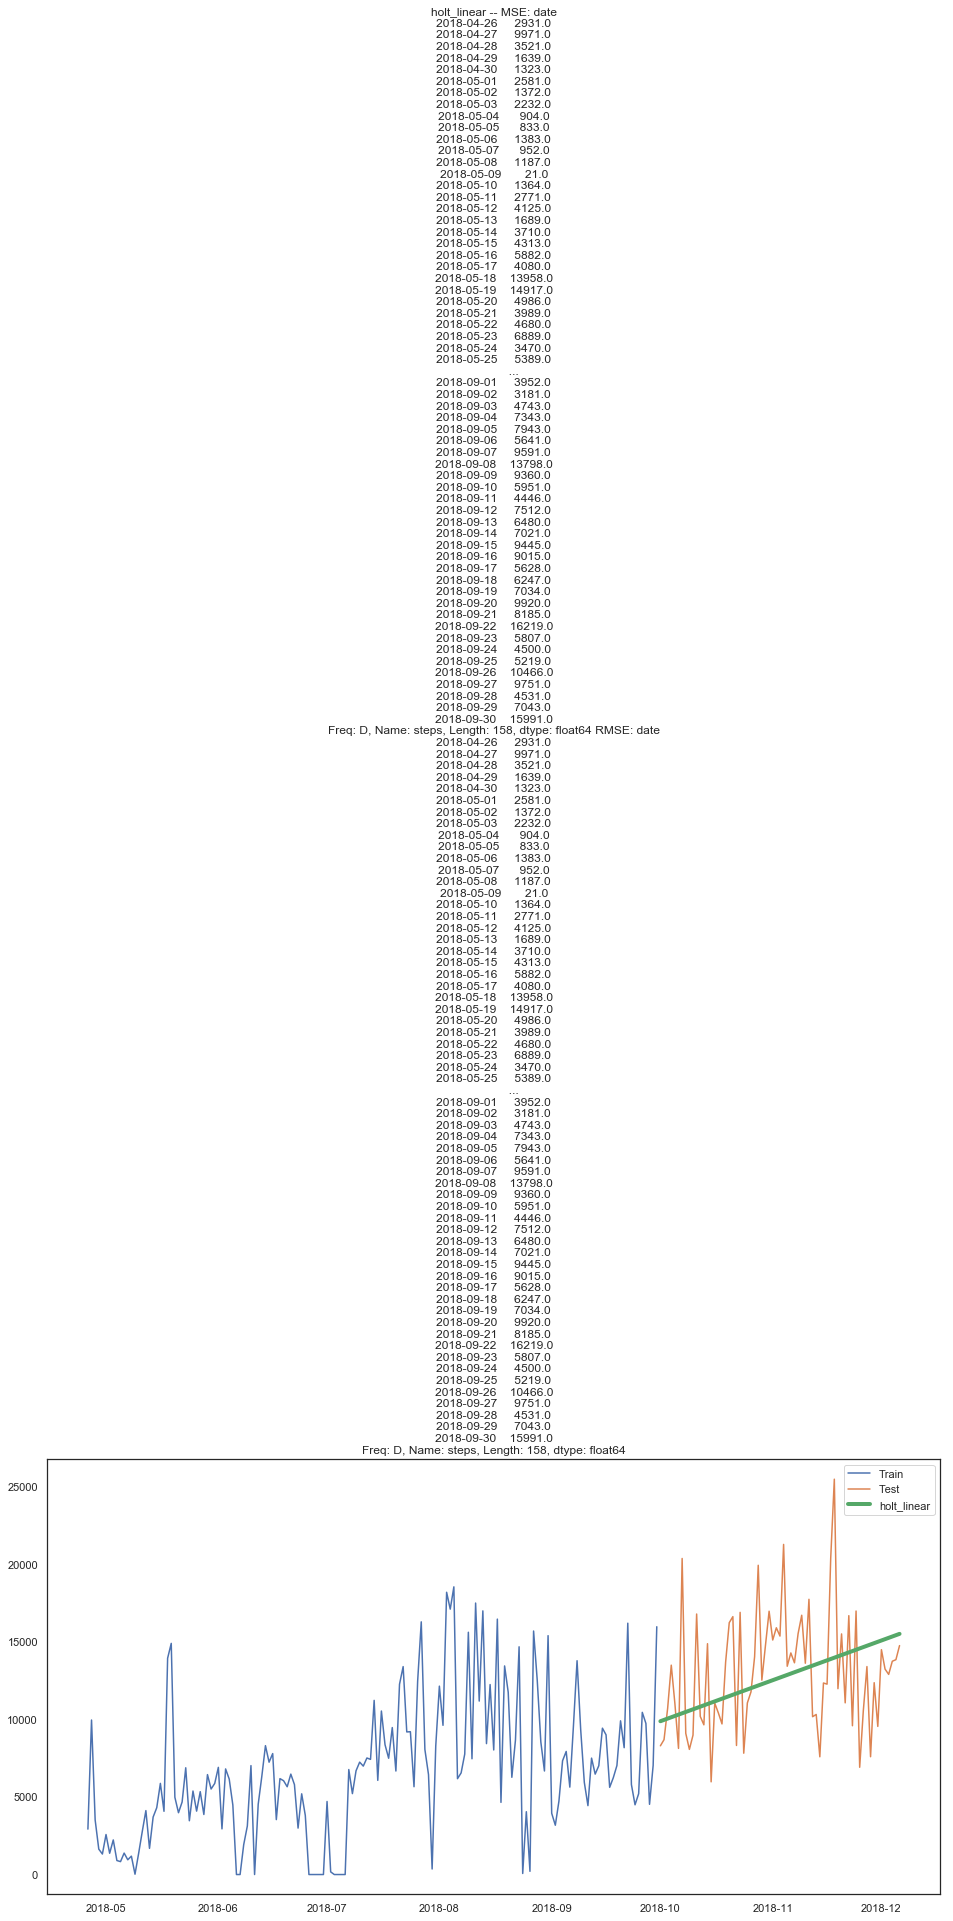

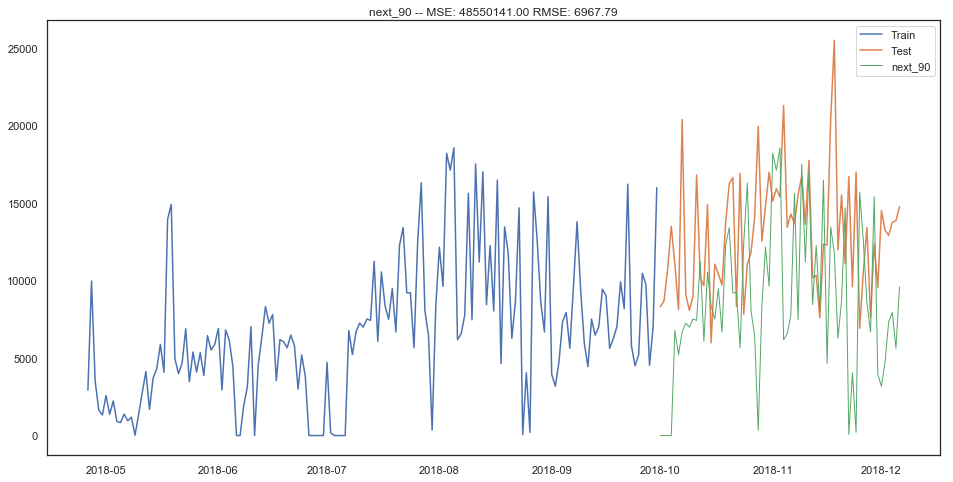

In [93]:
train = df['2018-04':'2018-09'].steps.resample('D').agg('mean')
test = df['2018-10':'2018-12'].steps.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']

holt = Holt(train).fit(smoothing_level=.3, smoothing_slope=.05)
yhat['holt_linear'] = holt.forecast(test.shape[0])
plot_and_eval(yhat.holt_linear, test, train)

using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

In [94]:
(yhat['diff']/yhat['actual']).median() # steps using mean --> 0.5001050316861501

0.5001050316861501

Observations: 225
Training Observations: 158
Testing Observations: 67


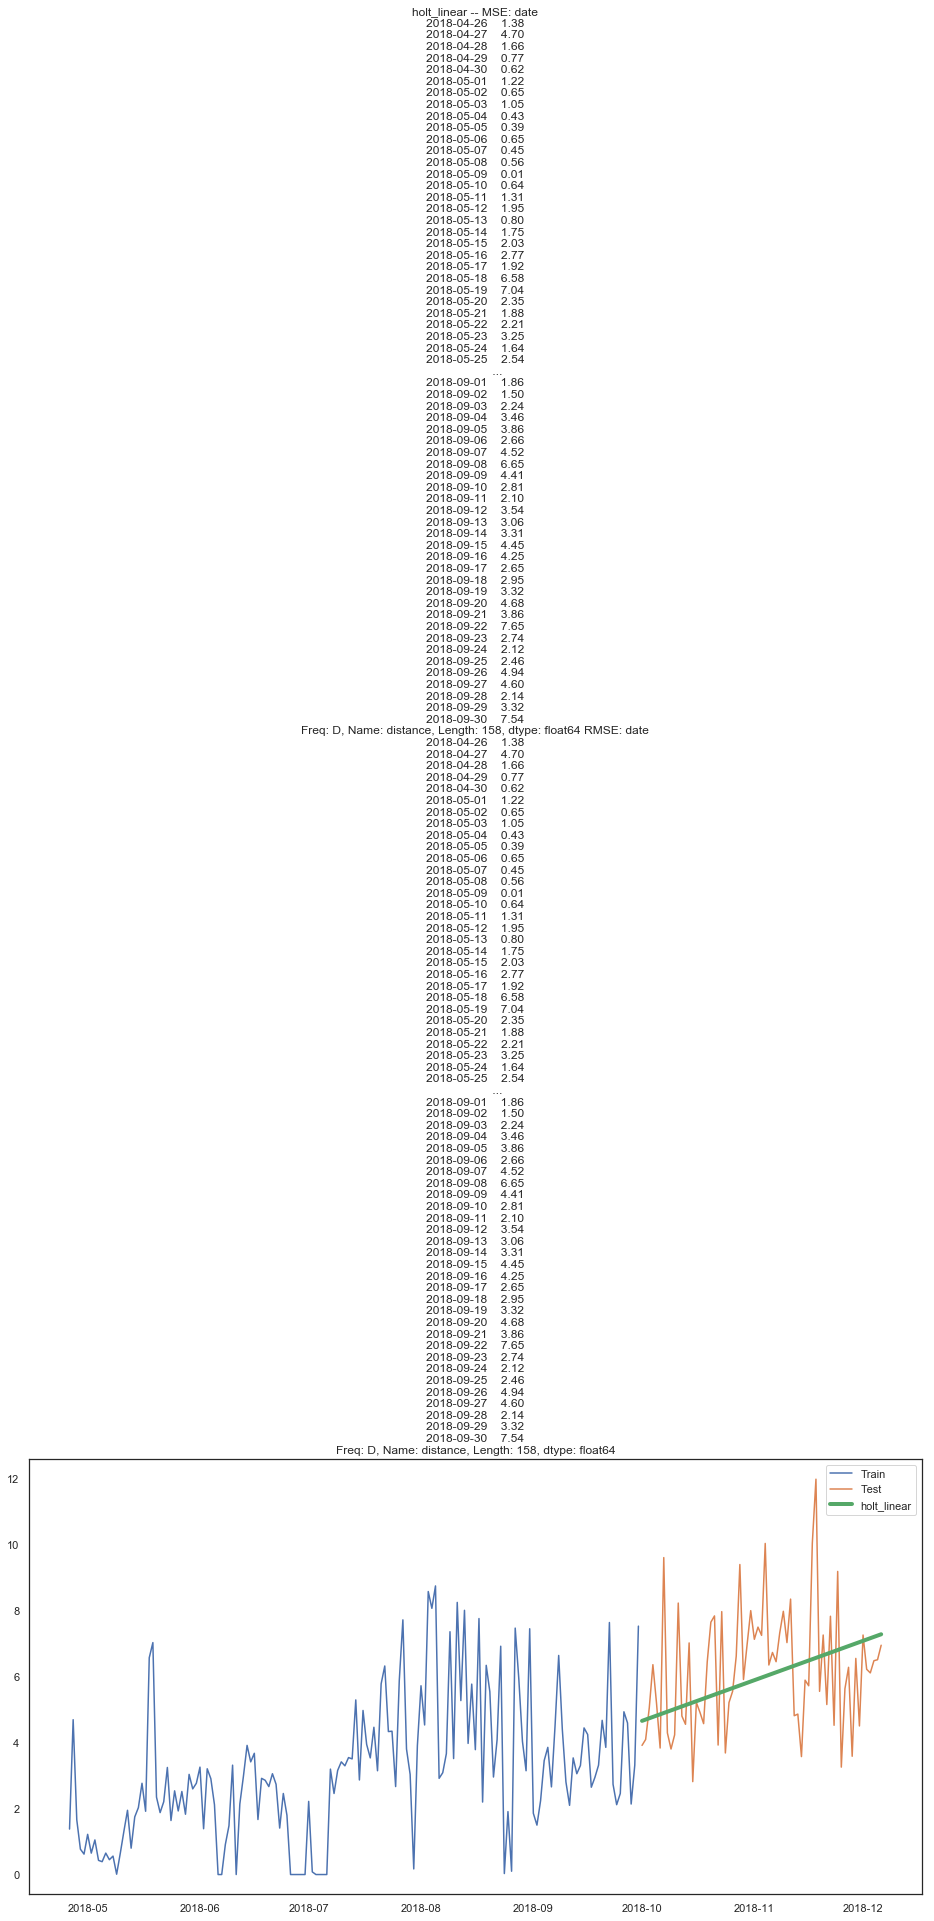

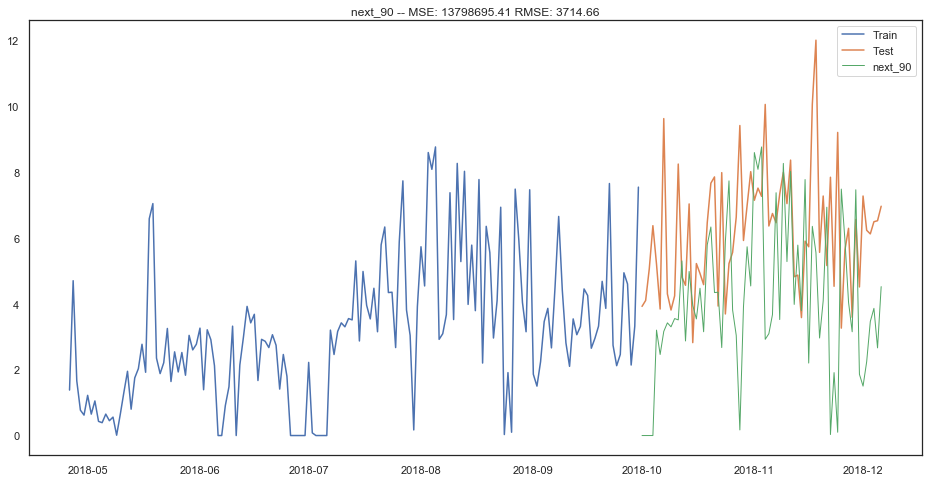

In [95]:
train = df['2018-04':'2018-09'].distance.resample('D').agg('mean')
test = df['2018-10':'2018-12'].distance.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']

holt = Holt(train).fit(smoothing_level=.3, smoothing_slope=.05)
yhat['holt_linear'] = holt.forecast(test.shape[0])
plot_and_eval(yhat.holt_linear, test, train)

using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

In [96]:
(yhat['diff']/yhat['actual']).median() # distance using mean --> 0.5025356704433399

0.5025356704433399

Observations: 225
Training Observations: 158
Testing Observations: 67


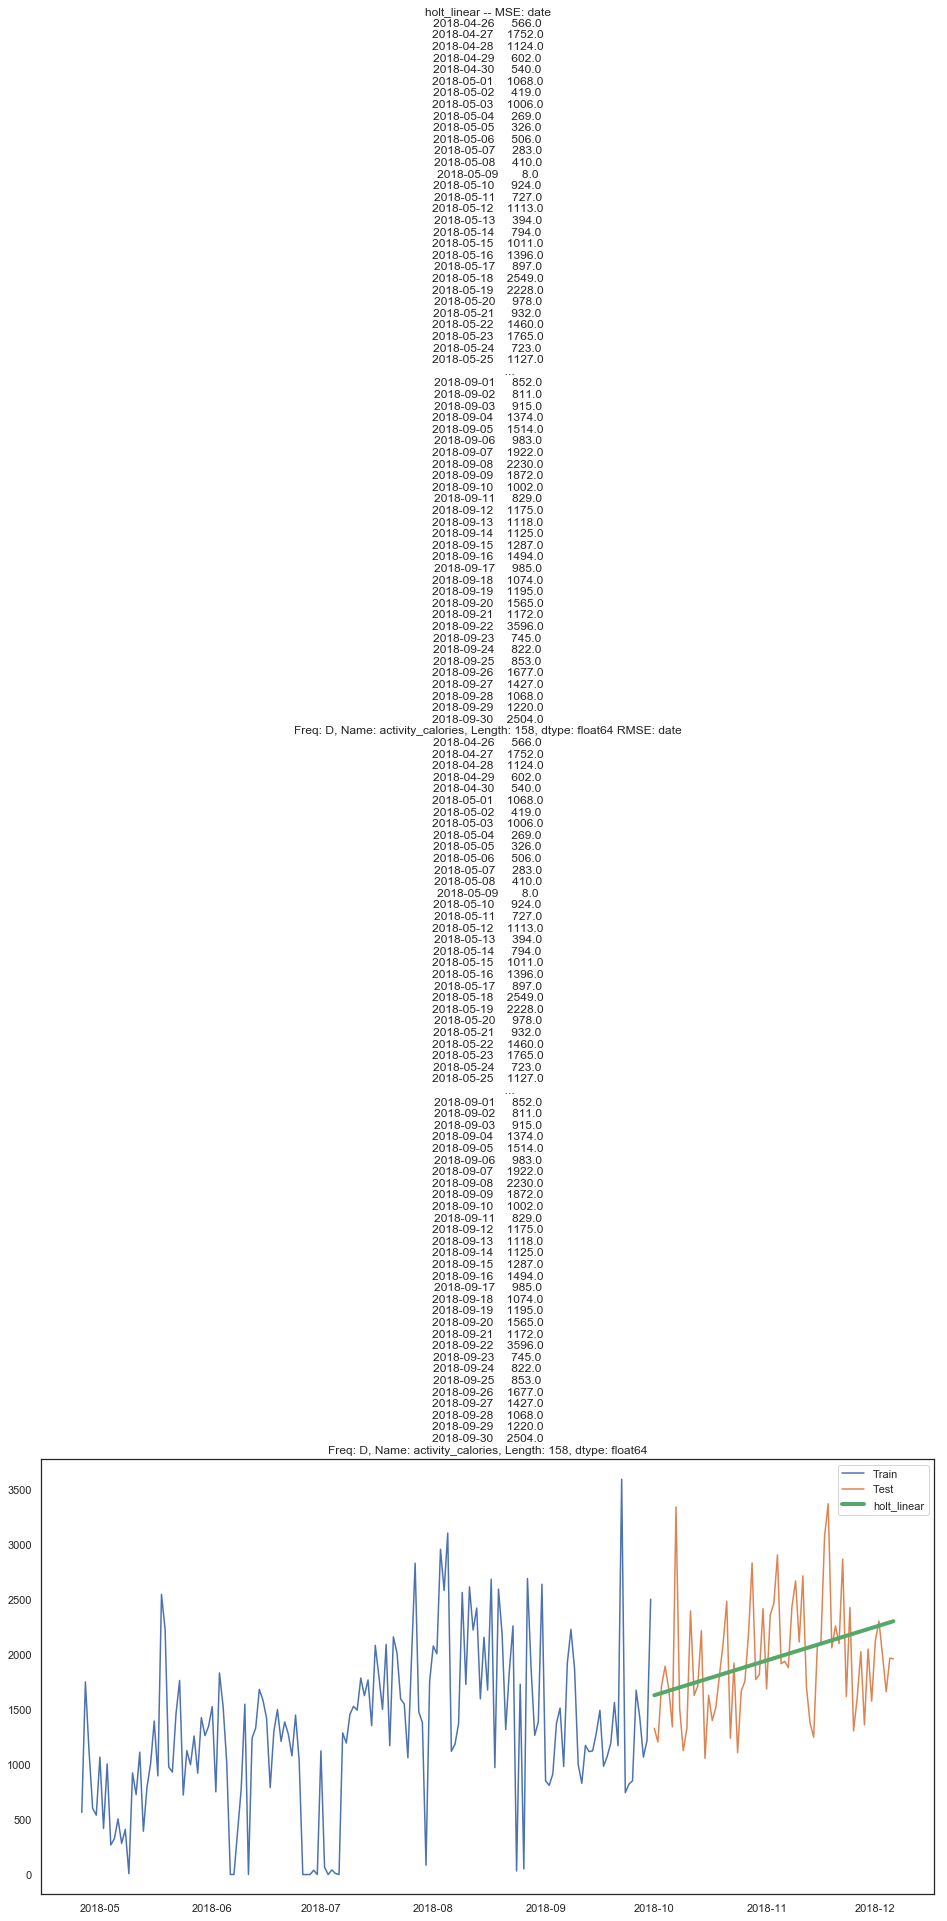

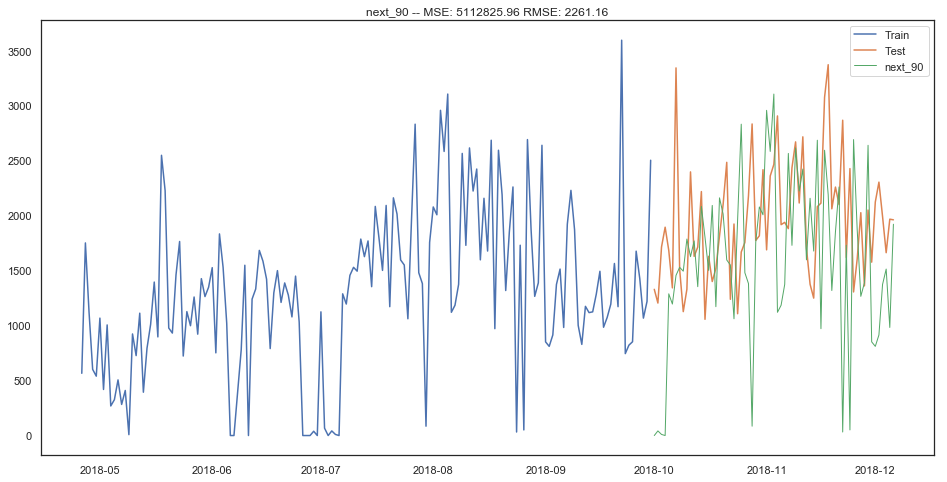

In [97]:
train = df['2018-04':'2018-09'].activity_calories.resample('D').agg('mean')
test = df['2018-10':'2018-12'].activity_calories.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']

holt = Holt(train).fit(smoothing_level=.3, smoothing_slope=.05)
yhat['holt_linear'] = holt.forecast(test.shape[0])
plot_and_eval(yhat.holt_linear, test, train)

using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

In [98]:
(yhat['diff']/yhat['actual']).median() # activity_calories using mean --> 0.32851995089821945

0.32851995089821945

Observations: 225
Training Observations: 158
Testing Observations: 67


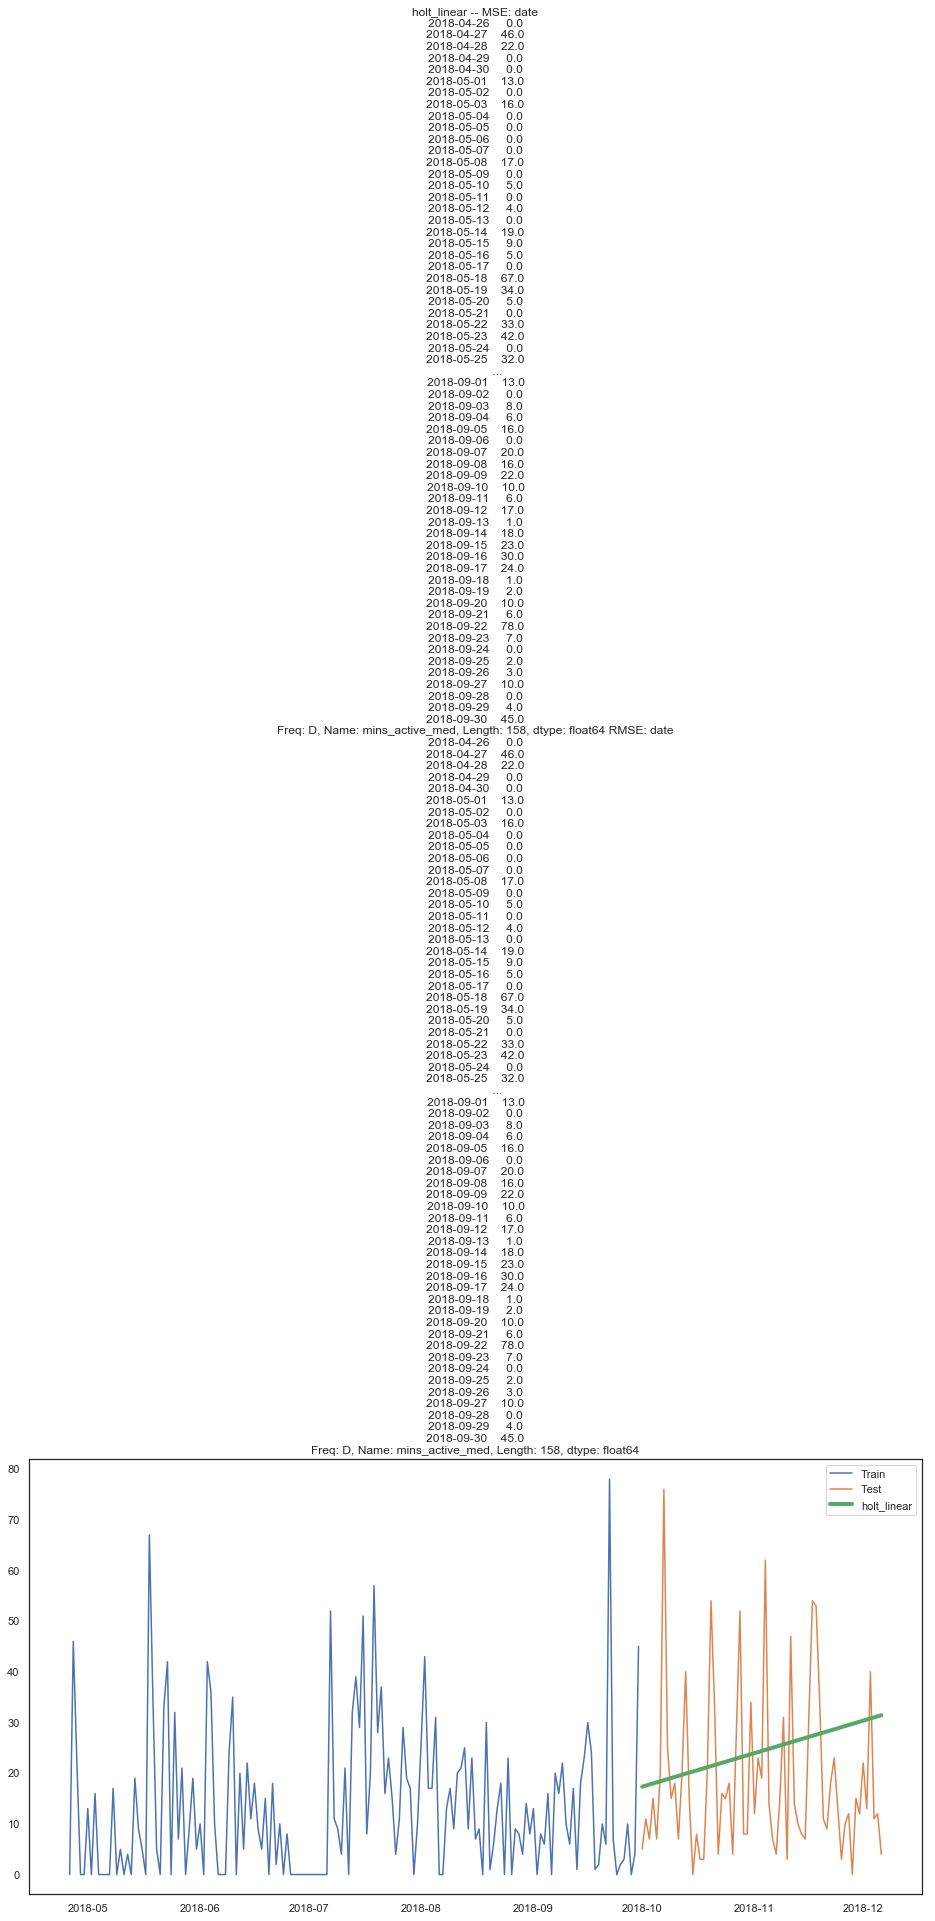

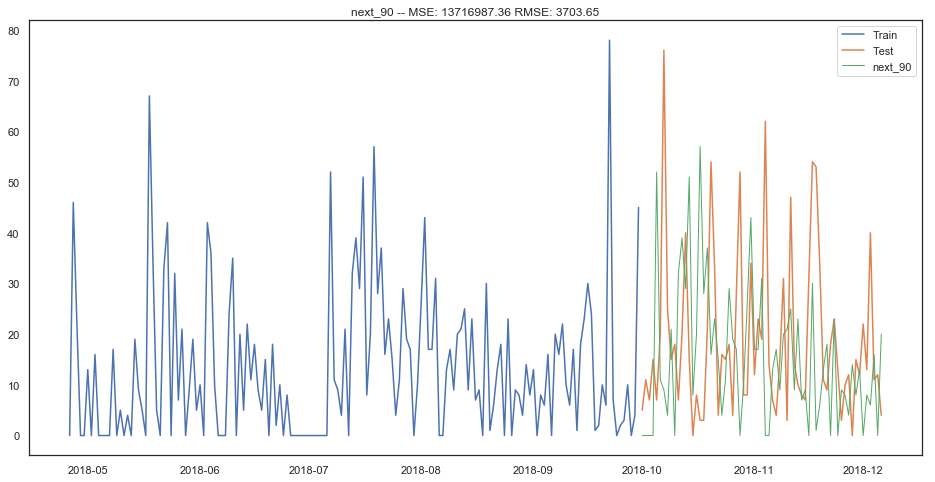

In [99]:
train = df['2018-04':'2018-09'].mins_active_med.resample('D').agg('mean')
test = df['2018-10':'2018-12'].mins_active_med.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']

holt = Holt(train).fit(smoothing_level=.3, smoothing_slope=.05)
yhat['holt_linear'] = holt.forecast(test.shape[0])
plot_and_eval(yhat.holt_linear, test, train)

using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

In [100]:
(yhat['diff']/yhat['actual']).median() # mins_active_med using mean --> 0.05470162748643759

0.05470162748643759

Observations: 225
Training Observations: 158
Testing Observations: 67


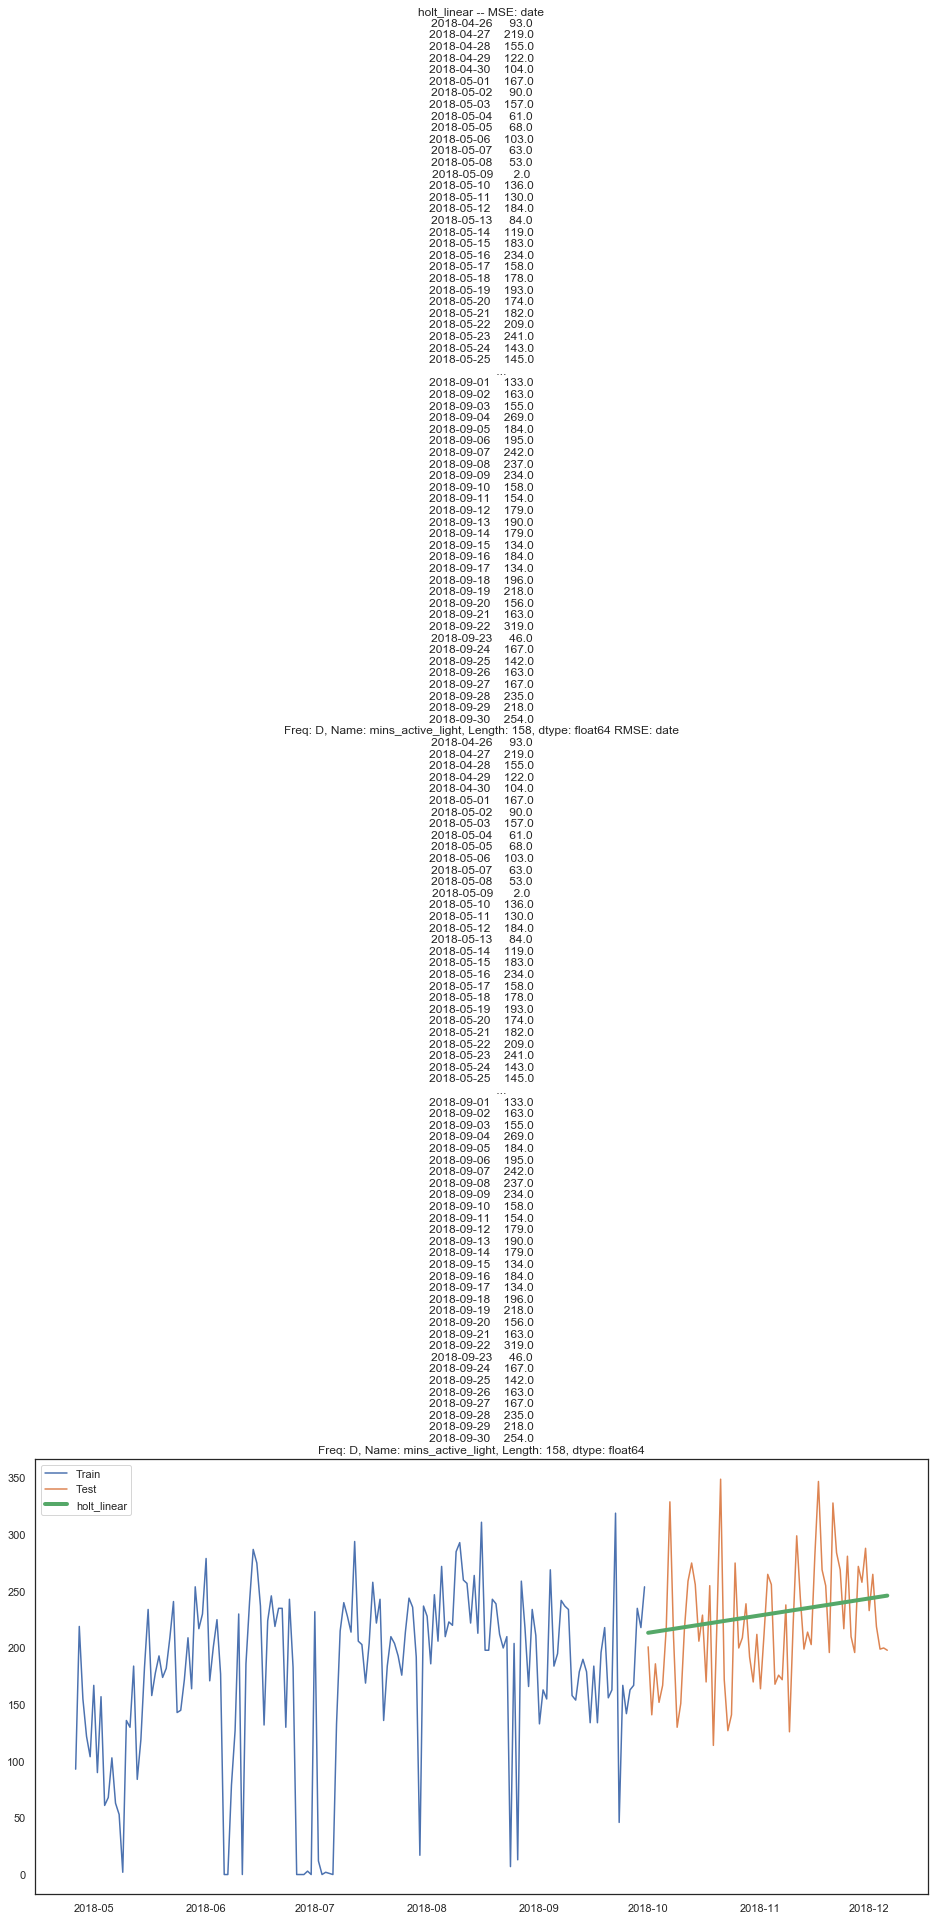

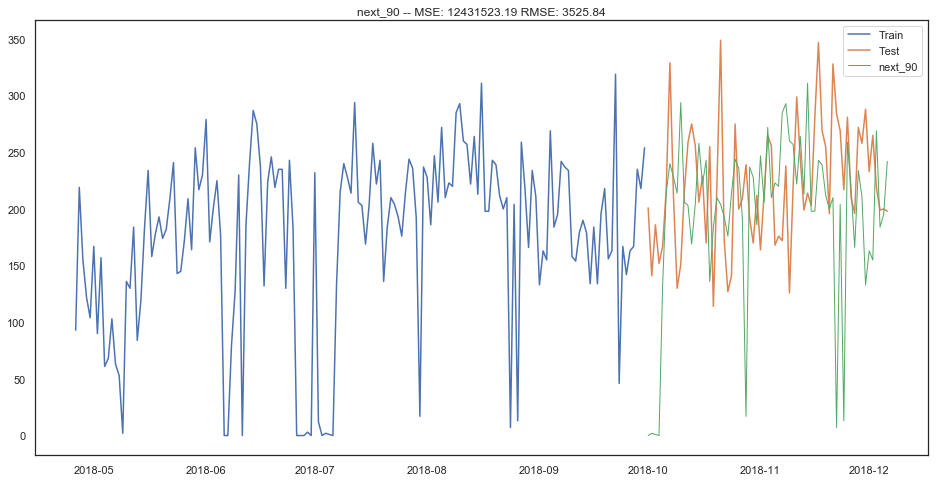

In [101]:
train = df['2018-04':'2018-09'].mins_active_light.resample('D').agg('mean')
test = df['2018-10':'2018-12'].mins_active_light.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']

holt = Holt(train).fit(smoothing_level=.3, smoothing_slope=.005)
yhat['holt_linear'] = holt.forecast(test.shape[0])
plot_and_eval(yhat.holt_linear, test, train)

using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

In [102]:
(yhat['diff']/yhat['actual']).median() # mins_active_light using mean --> 0.18499349343428373

0.18499349343428373

Observations: 225
Training Observations: 158
Testing Observations: 67


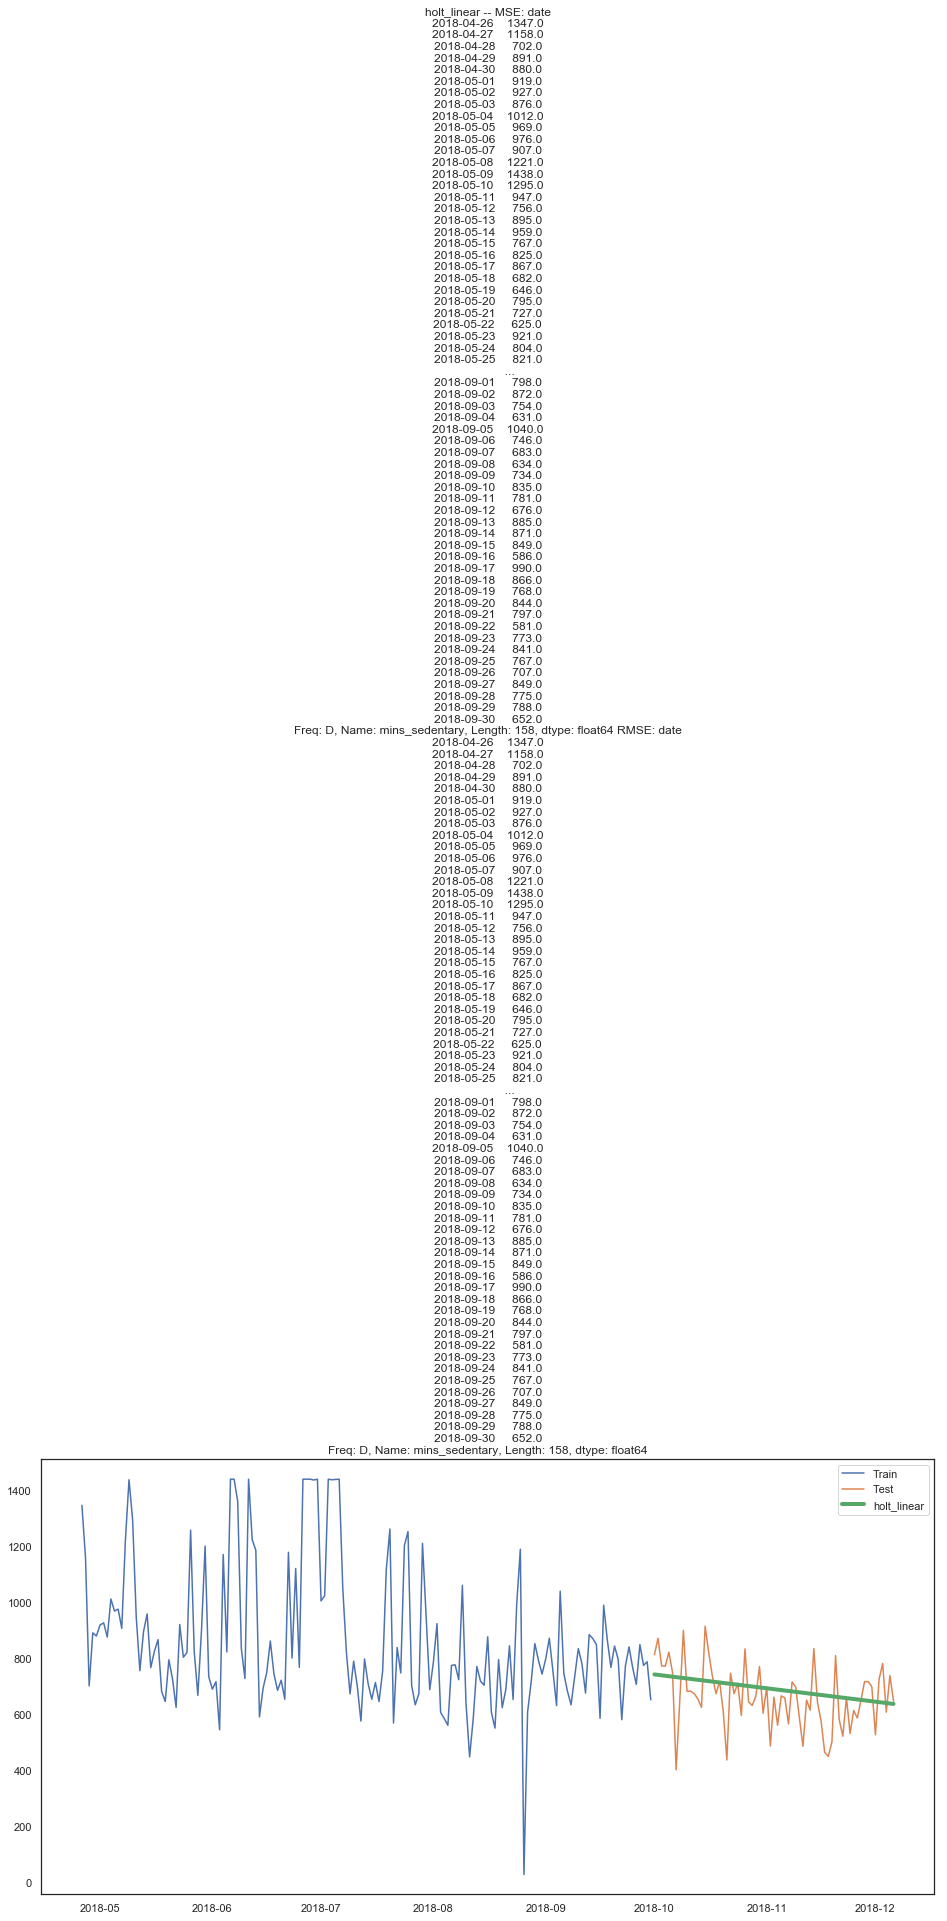

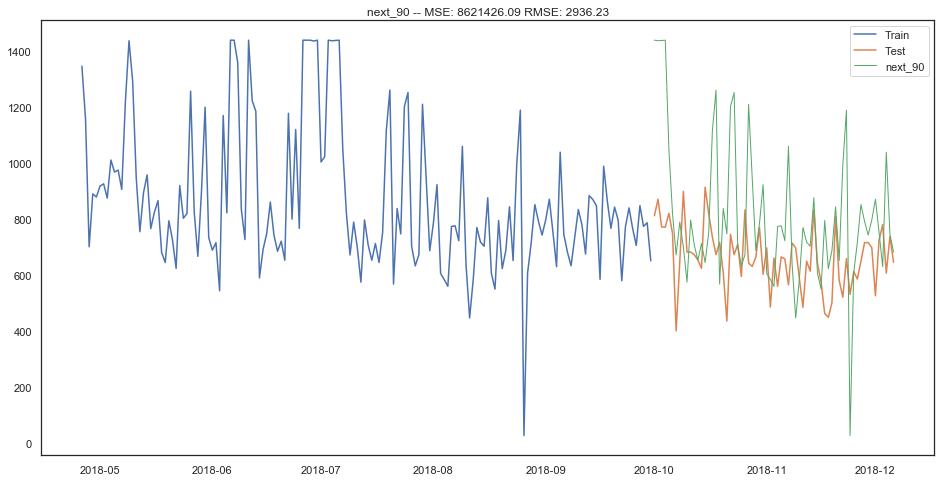

In [103]:
train = df['2018-04':'2018-09'].mins_sedentary.resample('D').agg('mean')
test = df['2018-10':'2018-12'].mins_sedentary.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']

holt = Holt(train).fit(smoothing_level=.3, smoothing_slope=.05)
yhat['holt_linear'] = holt.forecast(test.shape[0])
plot_and_eval(yhat.holt_linear, test, train)

using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

In [104]:
(yhat['diff']/yhat['actual']).median() # mins_sedentary using mean --> -0.31591074228459975

-0.31591074228459975

Observations: 225
Training Observations: 158
Testing Observations: 67


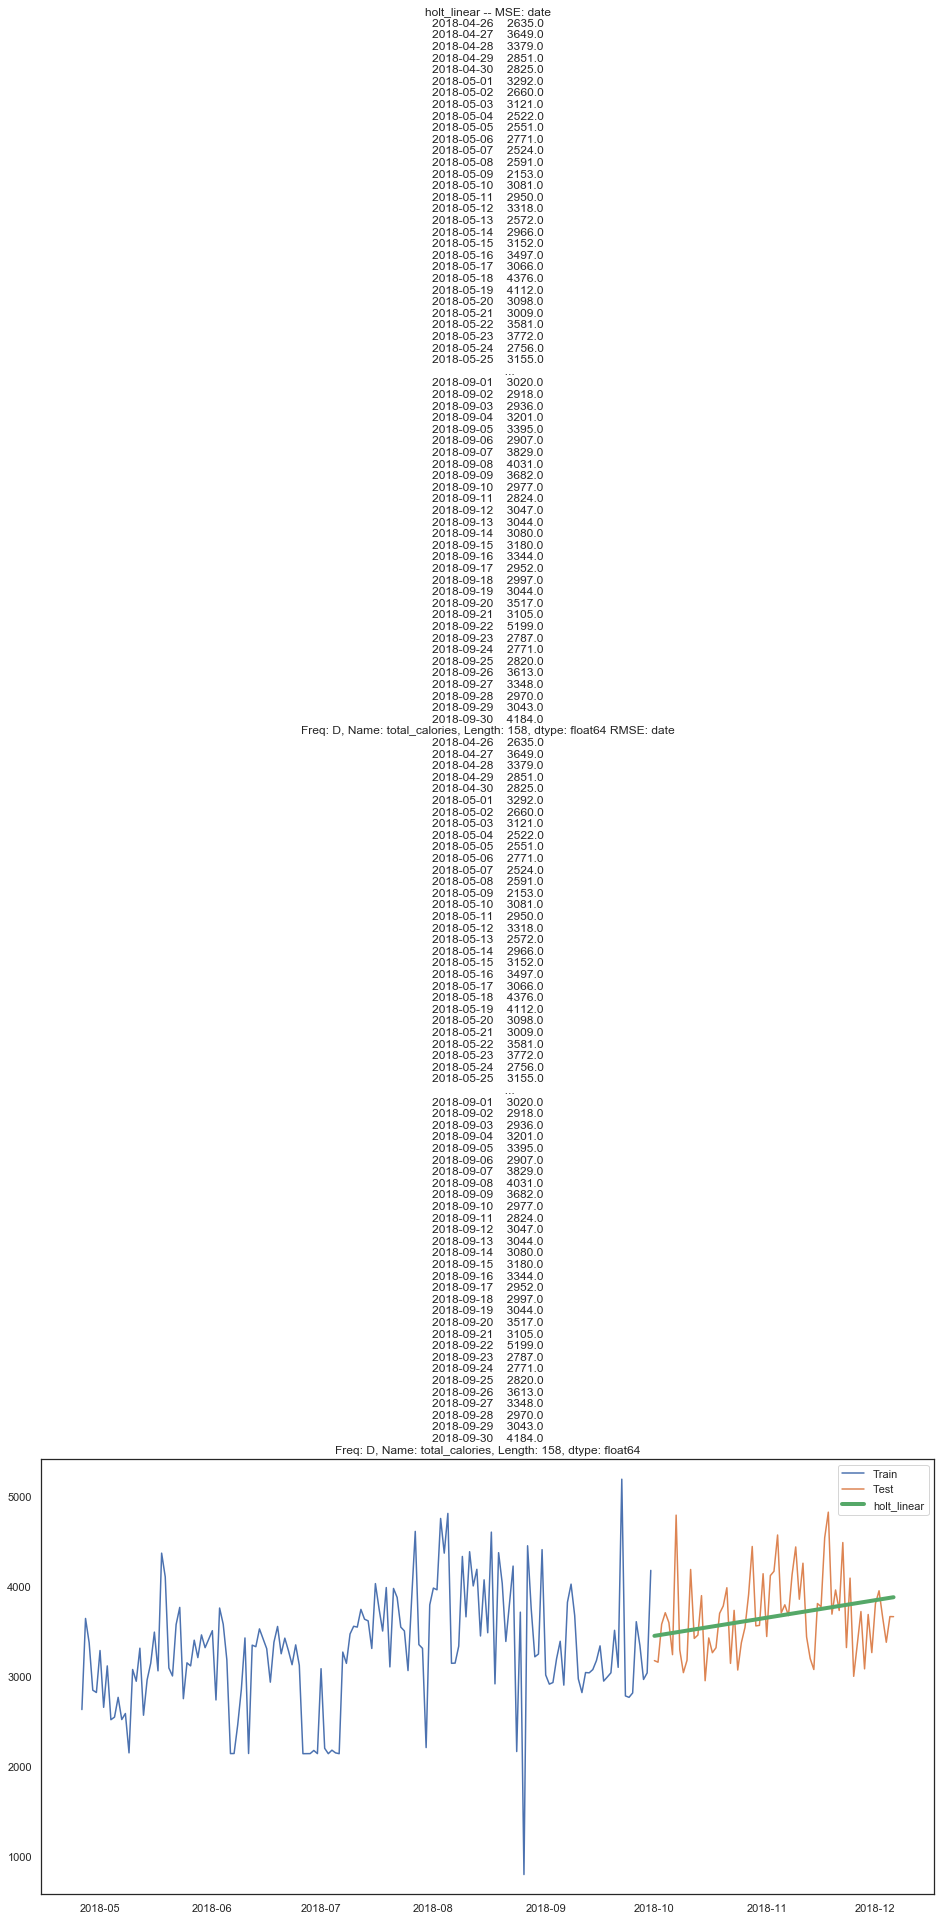

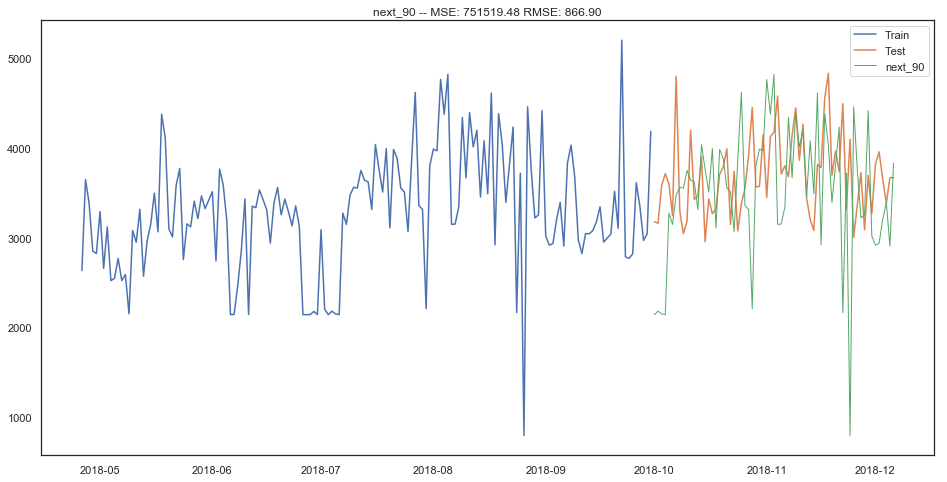

In [105]:
train = df['2018-04':'2018-09'].total_calories.resample('D').agg('mean')
test = df['2018-10':'2018-12'].total_calories.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']

holt = Holt(train).fit(smoothing_level=.3, smoothing_slope=.05)
yhat['holt_linear'] = holt.forecast(test.shape[0])
plot_and_eval(yhat.holt_linear, test, train)

using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

In [106]:
(yhat['diff']/yhat['actual']).median() # total_calories using mean --> 0.1092180509561587

0.1092180509561587

Observations: 225
Training Observations: 158
Testing Observations: 67


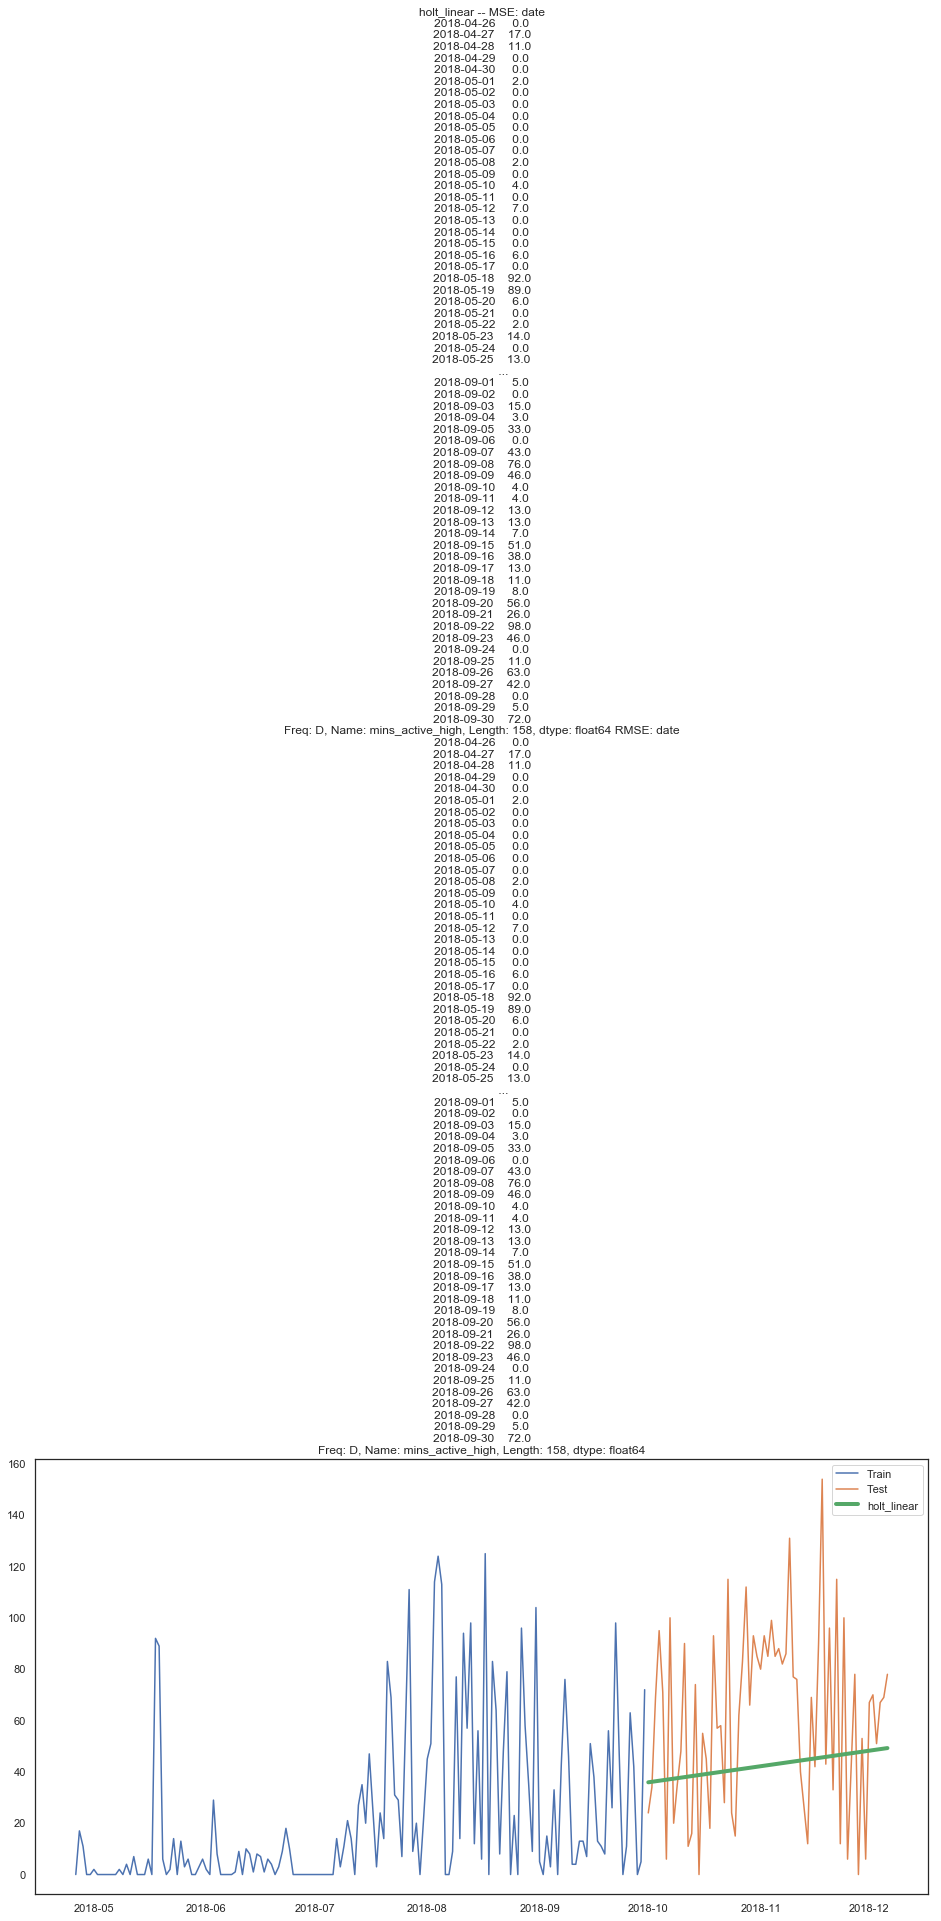

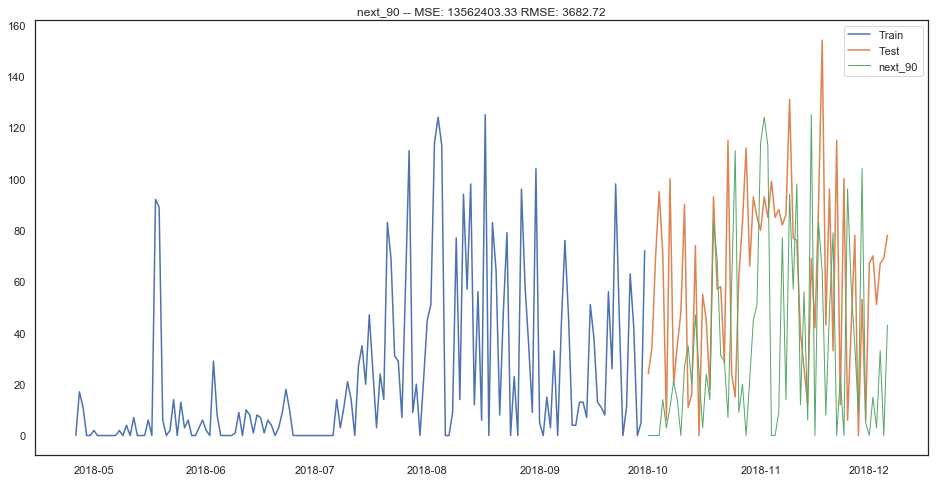

In [107]:
train = df['2018-04':'2018-09'].mins_active_high.resample('D').agg('mean')
test = df['2018-10':'2018-12'].mins_active_high.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']

holt = Holt(train).fit(smoothing_level=.3, smoothing_slope=.05)
yhat['holt_linear'] = holt.forecast(test.shape[0])
plot_and_eval(yhat.holt_linear, test, train)

using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

In [108]:
(yhat['diff']/yhat['actual']).median() # mins_active_high using mean --> 0.6676742867938787

0.6676742867938787

Observations: 225
Training Observations: 158
Testing Observations: 67


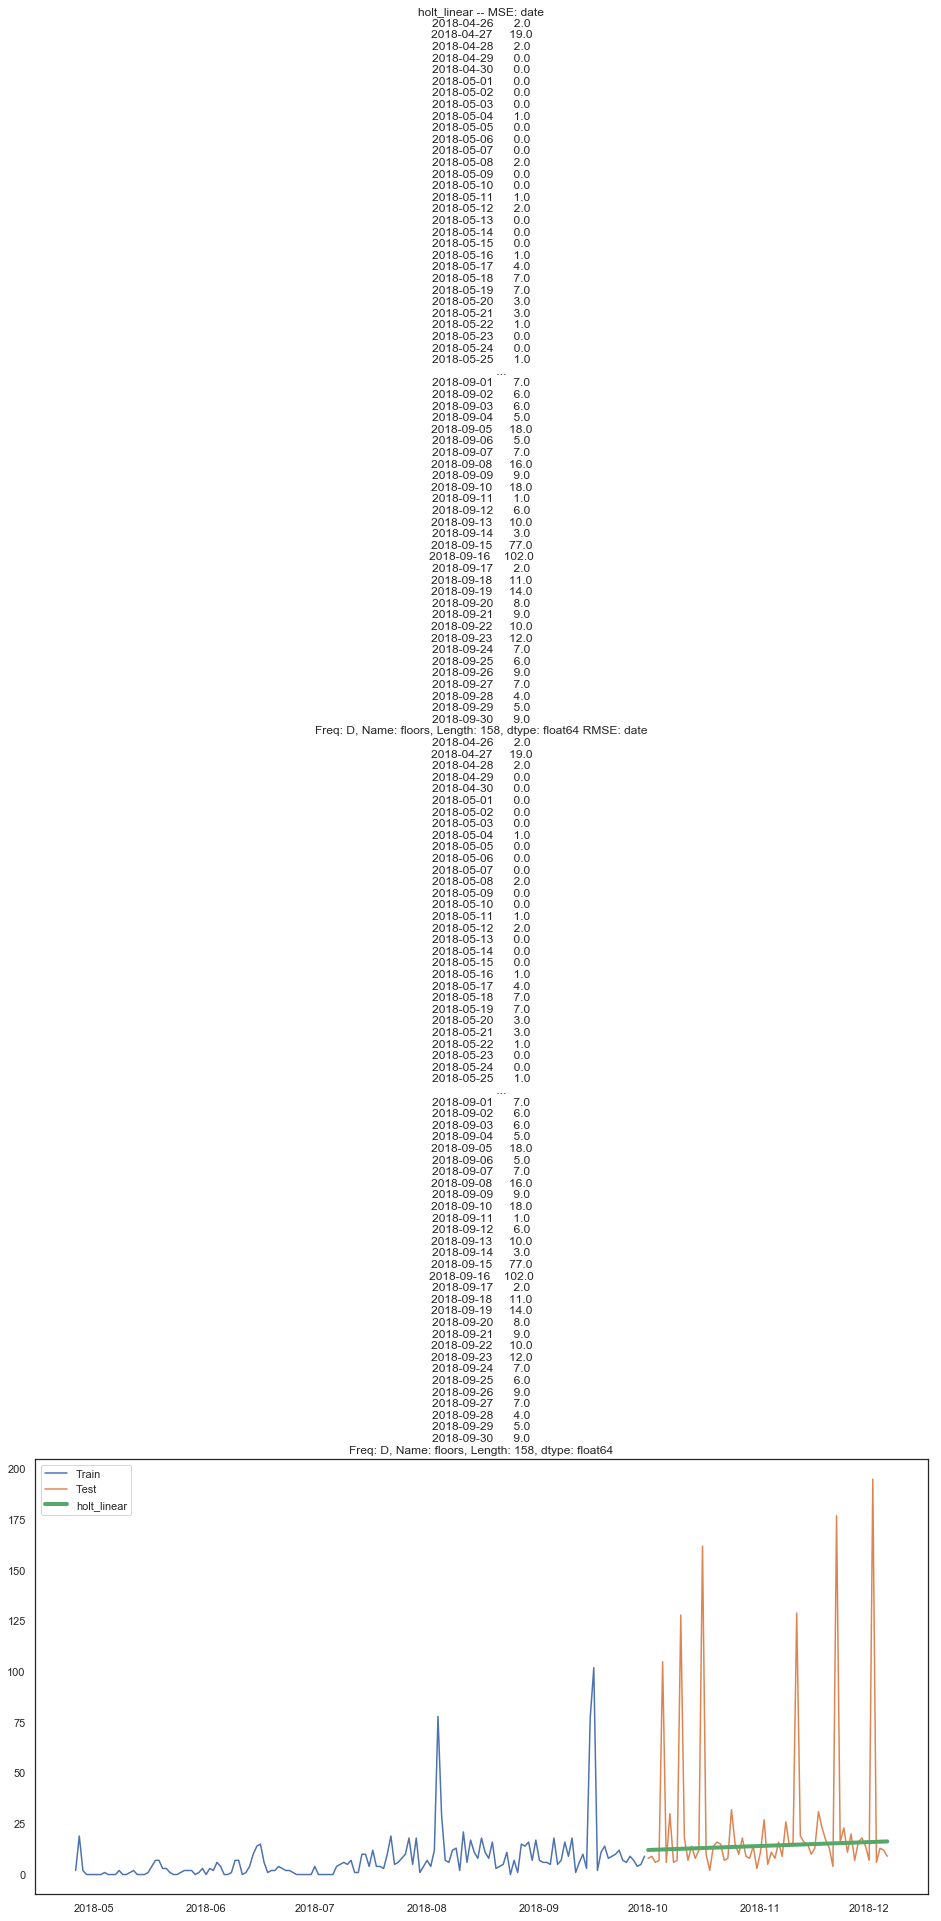

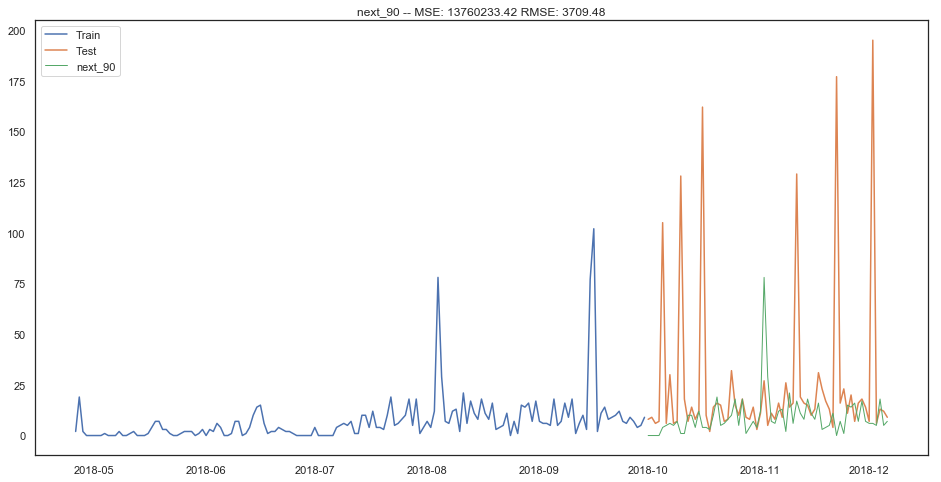

In [109]:
train = df['2018-04':'2018-09'].floors.resample('D').agg('mean')
test = df['2018-10':'2018-12'].floors.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']

holt = Holt(train).fit(smoothing_level=.1, smoothing_slope=.0001)
yhat['holt_linear'] = holt.forecast(test.shape[0])
plot_and_eval(yhat.holt_linear, test, train)

using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

In [110]:
(yhat['diff']/yhat['actual']).median() # floors using mean --> 0.4440116845180136

0.4440116845180136

Using Prophet to predict the missing values, we get 
abs(df_p['rmse'] - df[col].median())/ df_p['median'] per feature:

- steps------------------ 0.338
- distance--------------- 0.359
- activity_calories------ 0.471
- mins_active_med-------- 0.537
- mins_active_light------ 0.676
- mins_sedentary--------- 0.824
- total_calories--------- 0.827
- mins_active_high------- 2.057
- floors----------------- 2.572

Holts Linear Trend Model yielded for (yhat['diff']/yhat['actual']).median():

- mins_active_med using mean ----> 0.055....(smoothing_level=.3, smoothing_slope=.05)
- total_calories using mean -----> 0.109....(smoothing_level=.3, smoothing_slope=.05)
- mins_active_light using mean --> 0.185....(smoothing_level=.3, smoothing_slope=.005)
- mins_sedentary using mean ----> -0.316....(smoothing_level=.3, smoothing_slope=.05)
- activity_calories using mean --> 0.329....(smoothing_level=.3, smoothing_slope=.05)
- floors using mean -------------> 0.444....(smoothing_level=.1, smoothing_slope=.0001)
- steps using mean --------------> 0.500....(smoothing_level=.3, smoothing_slope=.05)
- distance using mean -----------> 0.503....(smoothing_level=.3, smoothing_slope=.05)
- mins_active_high using mean ---> 0.668....(smoothing_level=.3, smoothing_slope=.05)

# Best Model:

Observations: 225
Training Observations: 158
Testing Observations: 67


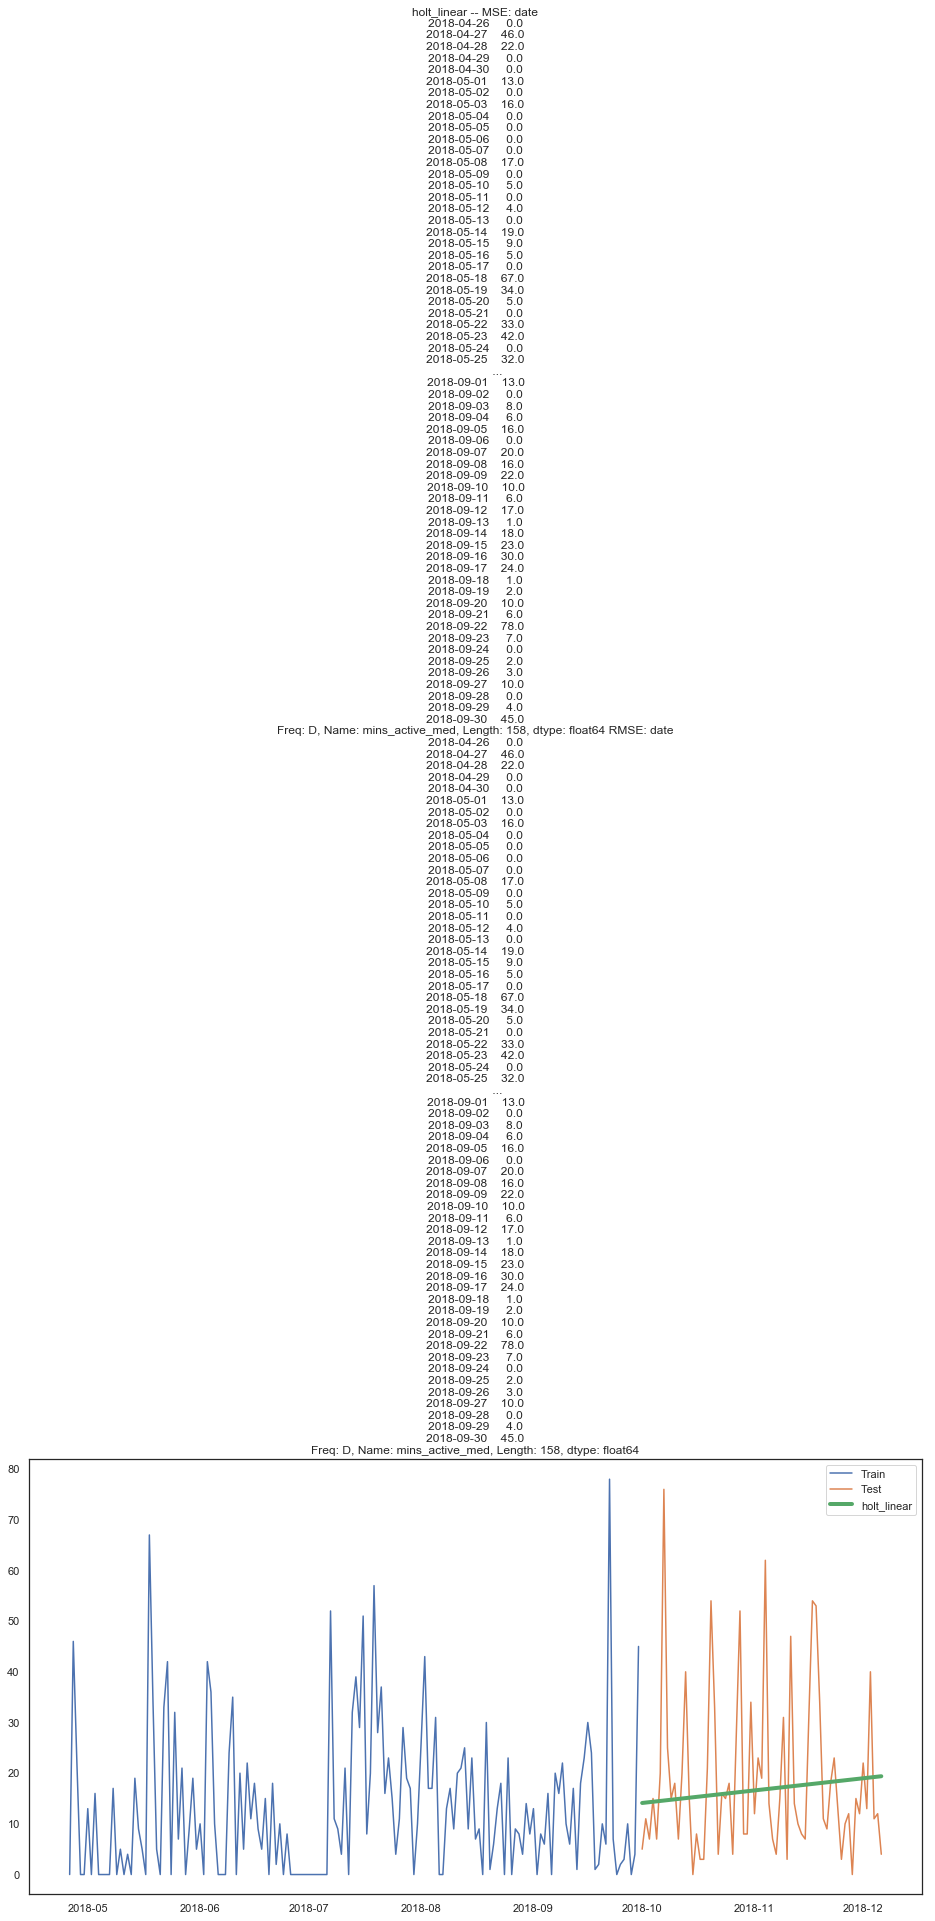

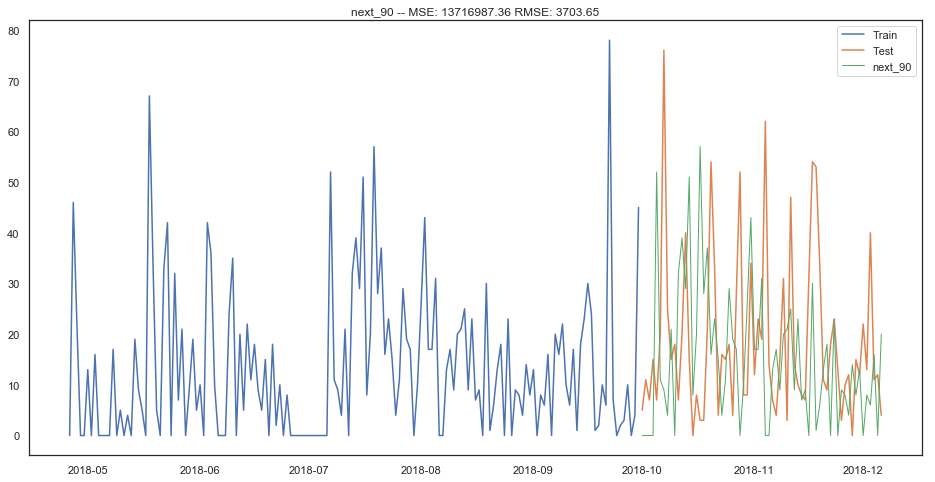

In [111]:
train = df['2018-04':'2018-09'].mins_active_med.resample('D').agg('mean')
test = df['2018-10':'2018-12'].mins_active_med.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']

holt = Holt(train).fit(smoothing_level=.1, smoothing_slope=.05)
yhat['holt_linear'] = holt.forecast(test.shape[0])
plot_and_eval(yhat.holt_linear, test, train)

using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

In [112]:
(yhat['diff']/yhat['actual']).median() # mins_active_med using mean --> 0.05470162748643759

0.05470162748643759

In [113]:
df.head(3).append(df.tail(3))

activity_calories  distance  floors  mins_active_high  \
date                                                                
2018-04-26              566.0      1.38     2.0               0.0   
2018-04-27             1752.0      4.70    19.0              17.0   
2018-04-28             1124.0      1.66     2.0              11.0   
2018-12-04             1663.0      6.49    13.0              67.0   
2018-12-05             1968.0      6.52    12.0              69.0   
2018-12-06             1962.0      6.96     9.0              78.0   

            mins_active_light  mins_active_med  mins_sedentary    steps  \
date                                                                      
2018-04-26               93.0              0.0          1347.0   2931.0   
2018-04-27              219.0             46.0          1158.0   9971.0   
2018-04-28              155.0             22.0           702.0   3521.0   
2018-12-04              199.0             11.0           608.0  13763.0   
2018-12-05              200.0             12.0           739.0  13865.0   
2018-12-06              198.0              4.0           647.0  14774.0   

            total_calories  
date                        
2018-04-26          2635.0  
2018-04-27          3649.0  
2018-04-28          3379.0  
2018-12-04          3384.0  
2018-12-05          3670.0  
2018-12-06          3669.0

# need to predict 2018-12-07 through 2018-12-28

Ran for one feature...

In [114]:
# holt = Holt(train).fit(smoothing_level=.1, smoothing_slope=.05)
predicted_data = holt.forecast(test.shape[0]+14)
predicted_data = predicted_data [-14:]
predicted_data.to_csv('predicted_data')

Now ran for all features, saving into a dataframe.

In [115]:
col_names = df.columns

In [117]:
predicted_data = pd.DataFrame()
for col in col_names:
    train = df['2018-04':'2018-09'][col].resample('D').agg('mean')
    test = df['2018-10':'2018-12'][col].resample('D').agg('mean')

    yhat = pd.DataFrame(dict(actual=test))
    yhat['holt_linear'] = train.mean()

    holt = Holt(train).fit(smoothing_level=.1, smoothing_slope=.05)
    predicted_data[col] = holt.forecast(test.shape[0]+14)[-14:]

predicted_data = predicted_data [-14:]
print(predicted_data)
predicted_data.to_csv('predicted_data')

            activity_calories  distance    floors  mins_active_high  \
2018-12-07        1001.186510  3.474703  6.811969         15.652332   
2018-12-08         996.153085  3.470026  6.725752         15.462406   
2018-12-09         991.119660  3.465349  6.639535         15.272480   
2018-12-10         986.086235  3.460673  6.553318         15.082554   
2018-12-11         981.052811  3.455996  6.467101         14.892628   
2018-12-12         976.019386  3.451319  6.380884         14.702701   
2018-12-13         970.985961  3.446642  6.294667         14.512775   
2018-12-14         965.952536  3.441965  6.208450         14.322849   
2018-12-15         960.919111  3.437288  6.122233         14.132923   
2018-12-16         955.885686  3.432612  6.036016         13.942997   
2018-12-17         950.852261  3.427935  5.949798         13.753071   
2018-12-18         945.818836  3.423258  5.863581         13.563144   
2018-12-19         940.785411  3.418581  5.777364         13.373218   
2018-1

Wrote to a csv file.

In [118]:
predicted_data.to_csv('predicted_data')

# Holt-Winters Method -- pretty sure this would be better if I had time to figure it out...

In [119]:
# y_hat_avg = test.copy()
# fit1 = ExponentialSmoothing(np.asarray(train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
# y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
# plt.figure(figsize=(16,8))
# plt.plot( train['Count'], label='Train')
# plt.plot(test['Count'], label='Test')
# plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
# plt.legend(loc='best')
# plt.show()